# __Analysis and Simulation of Bus Bunching__

Analysis and mathematical modeling, dedicated to the exploration of novel mechanisms to obtain the greatest benefit from the ever-growing amount of data generated in public transportation while dealing with signific, complex, noise and missing data.

Bus transportation systems in metropolis, such as São Paulo, are complex systems that constantly interacts with city dynamics. Understanding the behavior of this system under different contexts, such as day of the week, time of the day and holidays is vital for a better planning of bus transportation systems. This research proposes an approach to solving the problem that uses data generated by multiple sensors in-vehicle to directly counteract the cause of the bus bunching.

Data Base reference date from __2017-01-01__ until __2017-09-30__.

In [231]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from pymongo import MongoClient
import pickle
import seaborn as sns
import bokeh
import folium
import webbrowser
from shapely.geometry import Point, Polygon
import datetime
import matplotlib.dates as md
import time
pd.set_option('display.max_columns', None)
#from datetime import datetime, date, time, timedelta

%matplotlib inline

## __Ajuste da base e avaliações dos $\beta$ para cada link da linha 675K-10-0__

__Reunião 8/ago__

Calcular

$c_{(s_{link}),} \beta_{(s_{link}),} H_{(s_{link})}$: para diferentes horários e tipo de dia.

__Teste : Comparar em diferentes dias e horários.__

__Teste 2: Comparar evolução dos _headways_ usando valores médios x valores reais medidos.__

Histórico de seis meses e última hora (hora em hora).

__Exclusões:__

* Segundas, sextas, sábados e domingos,
* Feriados e pontes,
* Mês de julho,
* Excluir setembro para validação.

Verificar a estabilidade do modelo do Daganzo.

In [130]:
# open a file, where you ant to store the data 
with open('675K.pkl', 'rb') as input_file:
    route = pickle.load(input_file)
    
# open a file, where you ant to store the data 
with open('routeBetas_v10.pkl', 'rb') as input_file:
    routeBetas = pickle.load(input_file)
    
# code to save versions
file = open('routeBetas_v11.pkl', 'wb')
# dump information to that file
pickle.dump(routeBetas, file)
# close the file
file.close()

In [40]:
# fazendo o gráfico de travel time
links = ['(18032, 16066)',
 '(16066, 14997)',
 '(14997, 14998)',
 '(14998, 14999)',
 '(14999, 16018)',
 '(16018, 15784)',
 '(15784, 15785)',
 '(15785, 15006)',
 '(15006, 15007)',
 '(15007, 15008)',
 '(15008, 14192)',
 '(14192, 14193)',
 '(14193, 14194)',
 '(14194, 14955)',
 '(14955, 15010)',
 '(15010, 15011)',
 '(15011, 14695)',
 '(14695, 14696)',
 '(14696, 14697)',
 '(14697, 14698)',
 '(14698, 14699)',
 '(14699, 14700)',
 '(14700, 14701)',
 '(14701, 13751)',
 '(13751, 13752)',
 '(13752, 13753)',
 '(13753, 13754)',
 '(13754, 13755)',
 '(13755, 13756)',
 '(13756, 13757)',
 '(13757, 18033)',
 '(18033, 18034)',
 '(18034, 12498)',
 '(12498, 12499)',
 '(12499, 18035)',
 '(18035, 18036)']

In [41]:
cols = [('ltt', '(18032, 16066)'),
 ('ltt', '(16066, 14997)'),
 ('ltt', '(14997, 14998)'),
 ('ltt', '(14998, 14999)'),
 ('ltt', '(14999, 16018)'),
 ('ltt', '(16018, 15784)'),
 ('ltt', '(15784, 15785)'),
 ('ltt', '(15785, 15006)'),
 ('ltt', '(15006, 15007)'),
 ('ltt', '(15007, 15008)'),
 ('ltt', '(15008, 14192)'),
 ('ltt', '(14192, 14193)'),
 ('ltt', '(14193, 14194)'),
 ('ltt', '(14194, 14955)'),
 ('ltt', '(14955, 15010)'),
 ('ltt', '(15010, 15011)'),
 ('ltt', '(15011, 14695)'),
 ('ltt', '(14695, 14696)'),
 ('ltt', '(14696, 14697)'),
 ('ltt', '(14697, 14698)'),
 ('ltt', '(14698, 14699)'),
 ('ltt', '(14699, 14700)'),
 ('ltt', '(14700, 14701)'),
 ('ltt', '(14701, 13751)'),
 ('ltt', '(13751, 13752)'),
 ('ltt', '(13752, 13753)'),
 ('ltt', '(13753, 13754)'),
 ('ltt', '(13754, 13755)'),
 ('ltt', '(13755, 13756)'),
 ('ltt', '(13756, 13757)'),
 ('ltt', '(13757, 18033)'),
 ('ltt', '(18033, 18034)'),
 ('ltt', '(18034, 12498)'),
 ('ltt', '(12498, 12499)'),
 ('ltt', '(12499, 18035)'),
 ('ltt', '(18035, 18036)')]

In [42]:
mid_distance = [0.2882771770359505,
  0.761446752199638,
  1.1746723009601838,
  1.6314102816954044,
  2.09609427357913,
  2.7356383748447755,
  3.432216475479394,
  3.9176462506293848,
  4.248555850014698,
  4.596560169686359,
  4.920272175120676,
  5.340671146150992,
  6.1640799913309845,
  6.966214586217086,
  7.692604516173864,
  8.667745341684787,
  9.38884027235062,
  9.757381677273159,
  10.231257095527939,
  10.80549925495943,
  11.35820253341392,
  11.925478025110635,
  12.477932225987589,
  13.020438283235872,
  13.666072079649974,
  14.206691515089338,
  14.558123064836078,
  15.099085856376801,
  15.753316355554709,
  16.327373753622037,
  16.88142158917284,
  17.489301299303367,
  18.025755012764414,
  18.424913182269396,
  18.803669139075453,
  19.225077800814674,
  19.564259729210026]

In [43]:
# criando dataframe para os campos distância de cada link, distância acumulada da rota 
mid = []
for i in range(len(mid_distance)-1):
    mid.append(mid_distance[i+1] - mid_distance[i])
m = np.asarray(mid)
m = m.cumsum()
infra = pd.DataFrame(links, columns = ['link'])
infra['mid_distance'] = mid
infra['distance_acc'] = m
infra['link_id'] = np.arange(0,36)
#routeBetas = pd.merge(routeBetas, infra, on = 'link')

In [55]:
# Replace specific values in dataframe
base = routeBetas[routeBetas['link_id']==0]
df = base[['new_date', 'travel_id']]
mini = df.groupby('new_date')['travel_id'].min().tolist()

In [137]:
# zerar os Hplans das primeiras viagens do dia
for index, row in routeBetas.iterrows():
    if (row['travel_id'] in mini): #& (row['link'] == '(12498, 12499)')
        routeBetas.loc[index, 'Hplan'] = 0
        #break

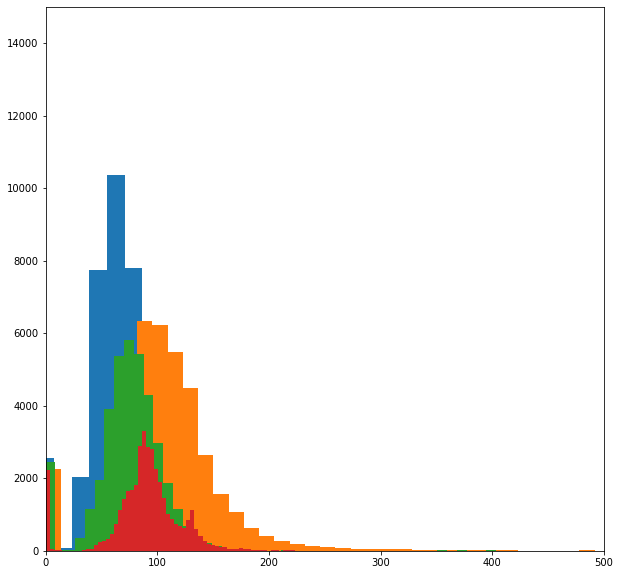

In [391]:
plt.rcParams["figure.figsize"]=10,10
plt.hist(routeBetas[routeBetas['link'] == '(14997, 14998)'].ltt, bins = 300)
plt.axis([0,500, 0, 7000])

plt.rcParams["figure.figsize"]=10,10
plt.hist(routeBetas[routeBetas['link'] == '(16018, 15784)'].ltt, bins = 300)
plt.axis([0,500, 0, 7000])

plt.rcParams["figure.figsize"]=10,10
plt.hist(routeBetas[routeBetas['link'] == '(14998, 14999)'].ltt, bins = 300)
plt.axis([0,500, 0, 7000])

plt.rcParams["figure.figsize"]=10,10
plt.hist(routeBetas[routeBetas['link'] == '(14999, 16018)'].ltt, bins = 300)
plt.axis([0,500, 0, 15000])

plt.show()

In [216]:
pd.to_datetime(routeBetas.loc[(routeBetas['travel_id'] == 1) & (routeBetas['link'] == '(18032, 16066)')]['c_s_hist_mean'], unit='m') + 

1219247   1970-01-01 01:35:11.822343960
Name: c_s_hist_mean, dtype: datetime64[ns]

In [237]:
routeBetas.loc[(routeBetas['travel_id'] == 1) & (routeBetas['link'] == '(18032, 16066)')]['aproxlinkstart']

1219247   2017-01-01 04:15:36
Name: aproxlinkstart, dtype: datetime64[ns]

In [59]:
linhas = list(set(routeBetas['travel_id']))

In [238]:
routeBetas.loc[(routeBetas['travel_id'] == 1) & (routeBetas['link'] == '(18032, 16066)')]['aproxlinkstart'] + pd.to_timedelta(routeBetas['c_s_hist_mean'], unit='s')[0]

1219247   2017-01-01 04:16:43.478777098
Name: aproxlinkstart, dtype: datetime64[ns]

In [242]:
pd.to_timedelta(routeBetas['ltt_acc'], unit='s')[0]

Timedelta('0 days 00:41:23.264962')

In [807]:
#routeBetas.sort_values(['travel_id','link_id'], axis=0,ascending=True, inplace=True)
#Hplan
routeH = routeBetas.copy()[routeBetas['link'] == '(18032, 16066)']
#routeH.drop(['Hplan'], axis = 1, inplace = True)
routeBetas.sort_values(['travel_id'], axis=0,ascending=True, inplace=True)
routeH['Hplan'] = (routeH['aproxlinkstart'] - routeH['aproxlinkstart'].shift()).dt.total_seconds()
for index, row in routeH.iterrows():
    if row['new_travel_id'] == 0:
        routeH.loc[index, 'Hplan'] = 0
routeBetas = pd.merge(routeBetas, routeH, on = 'travel_id')

In [73]:
# Criando a tabela para o cálculo dos cs's
routeBetas.drop(['new_travel_id'], axis = 1, inplace = True)

KeyError: "['new_travel_id'] not found in axis"

In [75]:
routeBetas.head()

_id          aproxlinkstart            link  \
0  5c76efc0bd8143570ffe4377 2017-01-01 04:15:36.000  (18032, 16066)   
1  5c76efc0bd8143570ffedbb3 2017-01-01 04:17:10.447  (16066, 14997)   
2  5c76efc1bd8143570fff73ef 2017-01-01 04:18:55.170  (14997, 14998)   
3  5c76efc1bd8143570f000c2c 2017-01-01 04:20:08.713  (14998, 14999)   
4  5c76efc2bd8143570f00a468 2017-01-01 04:20:54.518  (14999, 16018)   

          ltt  travel_id    trip_id  dayweek    new_date         new_time  \
0   94.447516          1  675K-10-0        6  2017-01-01         04:15:36   
1  104.722872          1  675K-10-0        6  2017-01-01  04:17:10.447000   
2   73.543434          1  675K-10-0        6  2017-01-01  04:18:55.170000   
3   45.804764          1  675K-10-0        6  2017-01-01  04:20:08.713000   
4   78.239041          1  675K-10-0        6  2017-01-01  04:20:54.518000   

   hour  mid_distance  distance_acc  link_id     ltt_acc           init_time  \
0     4      0.473170      0.473170        0   94.447516 2017-01-01 04:15:36   
1     4      0.413226      0.886395        1  199.170388 2017-01-01 04:15:36   
2     4      0.456738      1.343133        2  272.713823 2017-01-01 04:15:36   
3     4      0.464684      1.807817        3  318.518587 2017-01-01 04:15:36   
4     4      0.639544      2.447361        4  396.757628 2017-01-01 04:15:36   

       speed  c_s_hist_mean  c_s_hist_median  c_s_hist_std  c_s_hist_mean_cc  \
0  18.035524      90.700393        91.863445     21.453485         90.700393   
1  14.205225      85.515055        81.777502     26.269047        176.215448   
2  22.357628      55.461073        52.741397     16.693204        231.676521   
3  36.521580      60.136779        58.606029     14.374930        291.813300   
4  29.427237      80.489711        79.411584     14.839950        372.303011   

   c_s_hist_median_cc             ideal_travel_mean  \
0           91.863445 2017-01-01 04:15:36.000000000   
1          173.640947 2017-01-01 04:17:06.700392635   
2          226.382345 2017-01-01 04:18:32.215448066   
3          284.988374 2017-01-01 04:19:27.676521306   
4          364.399958 2017-01-01 04:20:27.813300059   

            ideal_travel_median  Hplan  headway_mean  headway_median  headway  \
0 2017-01-01 04:15:36.000000000    0.0           0.0             0.0      0.0   
1 2017-01-01 04:17:07.863445308    0.0           0.0             0.0      0.0   
2 2017-01-01 04:18:29.640947467    0.0           0.0             0.0      0.0   
3 2017-01-01 04:19:22.382344762    0.0           0.0             0.0      0.0   
4 2017-01-01 04:20:20.988373685    0.0           0.0             0.0      0.0   

    num_mean  den_mean  beta_mean  num_median  den_median  beta_median  
0   3.747124       0.0        NaN    2.584071         0.0          NaN  
1  19.207817       0.0        NaN   22.945370         0.0          NaN  
2  18.082361       0.0        NaN   20.802037         0.0          NaN  
3 -14.332014       0.0        NaN  -12.801265         0.0          NaN  
4  -2.250669       0.0        NaN   -1.172543         0.0          NaN

In [737]:
#Renumerando as viagens
first_trip = []
for i in linhas:
    if i in mini:
        first_trip.append(False)
    else:
        first_trip.append(True)
        
df2 = pd.DataFrame(first_trip)
df2['travel_id'] = linhas
teste = []
for i in range(len(first_trip)):
    if df2[0][i] == False:
        teste.append(0)
        x = 0
    else:
        teste.append(df2[0][i] + x)
        x += 1

df2['new_travel_id'] = teste
df2.drop(0, axis = 1, inplace= True)
df2.set_index('travel_id', inplace = True)

testenuclear = []
for index, row in routeBetas.iterrows():
    testenuclear.append(df2.loc[row['travel_id'], 'new_travel_id'])
    
routeBetas['new_travel_id'] = testenuclear

In [89]:
# cs_hist acumulado - mean e median
routeBetas.sort_values(['travel_id', 'link_id'], axis=0,ascending=True, inplace=True)
cscc = routeBetas[['travel_id', 'link','c_s_hist_mean']]
csccm = cscc.groupby(['travel_id']).cumsum()
routeBetas['c_s_hist_mean_cc'] = csccm['c_s_hist_mean'].tolist()

csccmd = routeBetas[['travel_id', 'link','c_s_hist_median']]
csccmmd = csccmd.groupby(['travel_id']).cumsum()
routeBetas['c_s_hist_median_cc'] = csccmmd['c_s_hist_median'].tolist()

In [ ]:
# inclusão de coluna para o tempo inicial das viagens (usarei para calcular a viagem ideal)
tmstp = routeBetas[['link','travel_id',  'aproxlinkstart']]
tmstp = tmstp[tmstp['link'] == '(18032, 16066)']
#routeBetas.drop(['aproxlinkstart_y'], axis=1, inplace = True)
tmstp.rename(columns={"aproxlinkstart": "init_time"})
routeBetas = pd.merge(routeBetas, tmstp, on = 'travel_id')
#routeBetas = routeBetas.rename(columns={"aproxlinkstart": "init_time", 'aproxlinkstart_x':'aproxlinkstart'})
#tmstp.set_index('travel_id', inplace= True)
#dum = tmstp['travel_id'].tolist()

#init = []
#for index, row in routeBetas.iterrows():
#    if row['travel_id'] in dum:
#        init.append(tmstp.loc[row['travel_id'], 'aproxlinkstart'])
#    else:
#        init.append(np.NaN)
#routeBetas['init_time'] = init

In [109]:
# cálculo das trajetórias ideais
# mean
ideal = []
for index, row in routeBetas.iterrows():
    ideal.append(row['init_time'] + pd.to_timedelta(row['c_s_hist_mean_cc'], unit = 's'))
routeBetas['ideal_travel_mean'] = ideal

# median
idealm = []
for index, row in routeBetas.iterrows():
    idealm.append(row['init_time'] + pd.to_timedelta(row['c_s_hist_median_cc'], unit = 's'))
routeBetas['ideal_travel_median'] = idealm

In [112]:
# deslocamento da coluna para ficar correto o tempo de início no nó do link
routeBetas.ideal_travel_mean = routeBetas.ideal_travel_mean.shift(1)
routeBetas.ideal_travel_median = routeBetas.ideal_travel_median.shift(1)

# inserir o valor correto de início da viagem para o travel time planejado
for index, row in routeBetas.iterrows():
    if row['link'] == '(18032, 16066)':
        routeBetas.loc[index, 'ideal_travel_mean'] = row['init_time']  
        
for index, row in routeBetas.iterrows():
    if row['link'] == '(18032, 16066)':
        routeBetas.loc[index, 'ideal_travel_median'] = row['init_time']

In [225]:
# inserir o valor correto de início da viagem para o travel time planejado
for index, row in routeBetas.iterrows():
    if row['link'] == '(18032, 16066)':
        routeBetas.loc[index, 'ideal_travel_mean'] = row['init_time']  
        
for index, row in routeBetas.iterrows():
    if row['link'] == '(18032, 16066)':
        routeBetas.loc[index, 'ideal_travel_median'] = row['init_time']

In [180]:
# Headways
#routeBetas.sort_values(['link_id','travel_id'], axis=0,ascending=True, inplace=True)
routeBetas['headway'] = (routeBetas['aproxlinkstart'] - routeBetas['aproxlinkstart'].shift()).dt.total_seconds()

In [184]:
# ajustando o dataset pós cálculo dos headways
#routeBetas.sort_values(['travel_id','aproxlinkstart'], axis=0,ascending=True, inplace=True)

#zerando a primeira corrida
for index, row in routeBetas.iterrows():
    if row['travel_id'] == 1:
        routeBetas.loc[index, 'headway'] = 0
    else:
        break

# corrige os valores de headway para primeira viagem do dia
for index, row in routeBetas.iterrows():
    if (row['travel_id'] in mini):
        routeBetas.loc[index, 'headway'] = 0

In [156]:
# Por conta da naturez dinâmica do problema temos que calcular um Hplan para cada link. Diferente do trabalho do Daganzo que considera um valor fixo de schedule.

#routeBetas.sort_values(['link_id','travel_id'], axis=0,ascending=True, inplace=True)
routeBetas['headway_mean'] = (routeBetas['ideal_travel_mean'] - routeBetas['ideal_travel_mean'].shift()).dt.total_seconds()
routeBetas['headway_median'] = (routeBetas['ideal_travel_median'] - routeBetas['ideal_travel_median'].shift()).dt.total_seconds()

#zerando a primeira corrida
for index, row in routeBetas.iterrows():
    if row['travel_id'] == 1:
        routeBetas.loc[index, 'headway_mean'] = 0
        routeBetas.loc[index, 'headway_median'] = 0
    else:
        break
# zerando a primeira corrida do dia
for index, row in routeBetas.iterrows():
    if (row['travel_id'] in mini):
        routeBetas.loc[index, 'headway_median'] = 0

In [674]:
# corrige os valores de headway planejado (mean/median) para primeira viagem do dia
for index, row in routeBetas.iterrows():
    if (row['travel_id'] in mini):
        routeBetas.loc[index, 'Hplan_mean'] = 0
        routeBetas.loc[index, 'Hplan_median'] = 0

In [132]:
# Inclusão do número que representa o dia da semana
# Começando na segunda-feira (Monday = 0, Tuesday = 1, Wednesday = 2,Thursday = 3,  Friday = 4 ,  Saturday = 5, Sunday = 6)
# Inserção de duas colunas de data e horário para manipulação posterior (agrupamento)
route['dayweek'] = route['aproxlinkstart'].dt.dayofweek
route.sort_values(['link','aproxlinkstart'], axis=0,ascending=True, inplace=True)
route['new_date'] = [d.date() for d in route['aproxlinkstart']]
route['new_time'] = [d.time() for d in route['aproxlinkstart']]

In [121]:
# Obtendo os valores de headways no início de viagem.
routeH = routeBetas.copy()[routeBetas['link'] == '(18032, 16066)']
routeH['Hplan'] = (routeH['aproxlinkstart'] - routeH['aproxlinkstart'].shift()).dt.total_seconds()
routeH = routeH.fillna(0)
#routeH.head()
routeH.drop(['_id', 'aproxlinkstart', 'link', 'ltt', 'trip_id', 'dayweek', 'new_date', 'new_time', 'hour', 'mid_distance', 'distance_acc', 'link_id', 'ltt_acc', 'init_time', 'speed','c_s_hist_mean','c_s_hist_median', 'c_s_hist_std', 
                'c_s_hist_mean_cc', 'c_s_hist_median_cc', 'ideal_travel_mean','ideal_travel_median'], axis = 1, inplace = True)
routeBetas = pd.merge(routeBetas, routeH, on = 'travel_id')

# inclusão da coluna Hplan dos Headways de início de viagem no dataframe geral
#routeHt = routeH[['travel_id', 'Hplan']].fillna(0)
#routeHtdict = routeHt.set_index('travel_id')
#route = route.join(routeHtdict, on='travel_id')
#route.fillna(0, inplace = True)
#for index, row in routeBetas.iterrows():
#    if row['travel_id'] in mini:
#        routeBetas.loc[index, 'Hplan'] = 0

In [ ]:
#cálculo dos betas usando as médias
num = []
for index, row in routeBetas.iterrows():
    num.append(row['ltt'] - row['c_s_hist_mean'])
routeBetas['num_mean'] = num

den = []
for index, row in routeBetas.iterrows():
    den.append(row['headway'] - row['Hplan'])
routeBetas['den_mean'] = den

betas_mean = []
for index, row in routeBetas.iterrows():
    if row['den_mean'] == 0:
        betas_mean.append(np.nan)
    else:
        betas_mean.append(row['num_mean'] / row['den_mean'])
routeBetas['beta_mean'] = betas_mean

In [8]:
#cálculo dos betas usando as medianas
num = []
for index, row in routeBetas.iterrows():
    num.append(row['ltt'] - row['c_s_hist_median'])
routeBetas['num_median'] = num

den = []
for index, row in routeBetas.iterrows():
    den.append(row['headway'] - row['Hplan'])
routeBetas['den_median'] = den

betas_mean = []
for index, row in routeBetas.iterrows():
    if row['den_median'] == 0:
        betas_mean.append(np.nan)
    else:
        betas_mean.append(row['num_median'] / row['den_median'])
routeBetas['beta_median'] = betas_mean

In [7]:
#routeBetas.drop(['num_mean', 'den_mean'], axis = 1, inplace = True)
routeBetas = routeBetas.replace([np.inf, -np.inf], np.nan)

In [ ]:
# valores acumulados do ltt
tempo = routeBetas[['travel_id','ltt','link_id']].copy()
tempo.sort_values(['travel_id', 'link_id'], axis = 0, ascending = True, inplace = True)
tempo.drop(['link_id'], axis = 1, inplace = True)
tempo2 = tempo.groupby('travel_id').cumsum()
tempo3 = tempo2.values.tolist()
routeBetas.sort_values(['travel_id', 'aproxlinkstart'], axis = 0, ascending = True, inplace = True)
flat_list = [item for sublist in tempo3 for item in sublist]
routeBetas['ltt_acc'] = flat_list

In [61]:
#Speed
routeBetas['speed'] = (routeBetas['mid_distance']) / (routeBetas['ltt']/3600) 
routeBetas = routeBetas.replace([np.inf, -np.inf], np.nan)

In [ ]:
# Cálculo dos cs's
routeAdj.drop(['_id','travel_id', 'trip_id', 'new_date', 'hour', 'mid_distance', 'distance_acc', 'link_id', 'ltt_acc', 'init_time', 'speed'], axis = 1, inplace = True)

# calculando média, mediana e desvio padrão
route_mean = routeAdj.groupby(['link', 'dayweek', routeAdj['aproxlinkstart'].dt.hour]).mean()
route_std = routeAdj.groupby(['link', 'dayweek', routeAdj['aproxlinkstart'].dt.hour]).std()
route_median = routeAdj.groupby(['link', 'dayweek', routeAdj['aproxlinkstart'].dt.hour]).median()

route_mean = route_mean.unstack(['link'])
route_median = route_median.unstack(['link'])
route_std = route_std.unstack(['link'])
route_median[cols]
route_std[cols]
route_mean[cols]

In [155]:
routeBetas[(routeBetas['ltt'] <= 0) & (routeBetas['link'] == '(18032, 16066)')].head()

_id      aproxlinkstart            link  \
576    5c76efc0bd8143570ffe4387 2017-01-01 07:06:36  (18032, 16066)   
10426  5c76efc0bd8143570ffe449f 2017-01-03 08:46:12  (18032, 16066)   
13162  5c76efc0bd8143570ffe44eb 2017-01-03 17:12:58  (18032, 16066)   
18206  5c76efc0bd8143570ffe4579 2017-01-04 16:01:34  (18032, 16066)   
23610  5c76efc0bd8143570ffe4612 2017-01-05 16:02:44  (18032, 16066)   

               ltt  travel_id    trip_id  dayweek    new_date  new_time  hour  \
576     -17.025508         17  675K-10-0        6  2017-01-01  07:06:36     7   
10426    -3.000000        297  675K-10-0        1  2017-01-03  08:46:12     8   
13162   -36.014649        373  675K-10-0        1  2017-01-03  17:12:58    17   
18206   -42.695441        515  675K-10-0        2  2017-01-04  16:01:34    16   
23610 -3423.521752        668  675K-10-0        3  2017-01-05  16:02:44    16   

       mid_distance  distance_acc  link_id     ltt_acc           init_time  \
576         0.47317       0.47317        0  -14.556957 2017-01-01 07:06:36   
10426       0.47317       0.47317        0   -3.000000 2017-01-03 08:46:12   
13162       0.47317       0.47317        0  -35.244564 2017-01-03 17:12:58   
18206       0.47317       0.47317        0  286.997805 2017-01-04 16:01:34   
23610       0.47317       0.47317        0 -121.298405 2017-01-05 16:02:44   

            speed  c_s_hist_mean  c_s_hist_median  c_s_hist_std  \
576   -100.050492      89.808353        91.257137     22.939279   
10426 -567.803490     111.061110       100.446754     35.241810   
13162  -47.297712      99.511447        95.793777     28.888545   
18206  -39.896776     102.756511        95.793777     39.238356   
23610   -0.497561     100.472340        95.793777     36.017418   

       c_s_hist_mean_cc  c_s_hist_median_cc   ideal_travel_mean  \
576           89.808353           91.257137 2017-01-01 07:06:36   
10426        111.061110          100.446754 2017-01-03 08:46:12   
13162         99.511447           95.793777 2017-01-03 17:12:58   
18206        102.756511           95.793777 2017-01-04 16:01:34   
23610        100.472340           95.793777 2017-01-05 16:02:44   

      ideal_travel_median  Hplan  headway_mean  headway_median  headway  \
576   2017-01-01 07:06:36  807.0         807.0           807.0    807.0   
10426 2017-01-03 08:46:12  242.0         242.0           242.0    242.0   
13162 2017-01-03 17:12:58  491.0         491.0           491.0    491.0   
18206 2017-01-04 16:01:34  421.0         421.0           421.0    421.0   
23610 2017-01-05 16:02:44  225.0         225.0           225.0    225.0   

          num_mean  den_mean  beta_mean   num_median  den_median  beta_median  
576    -106.833861       0.0        NaN  -108.282645         0.0          NaN  
10426  -114.061110       0.0        NaN  -103.446754         0.0          NaN  
13162  -135.526095       0.0        NaN  -131.808426         0.0          NaN  
18206  -145.451952       0.0        NaN  -138.489218         0.0          NaN  
23610 -3523.994091       0.0        NaN -3519.315529         0.0          NaN

In [171]:
routeBetas[routeBetas['travel_id'] == 150]

_id          aproxlinkstart            link  \
5254  5c76efc0bd8143570ffe440c 2017-01-02 10:06:58.000  (18032, 16066)   
5255  5c76efc0bd8143570ffedc48 2017-01-02 10:09:09.633  (16066, 14997)   
5256  5c76efc1bd8143570fff7484 2017-01-02 10:11:48.288  (14997, 14998)   
5257  5c76efc1bd8143570f000cc1 2017-01-02 10:13:08.936  (14998, 14999)   
5258  5c76efc2bd8143570f00a4fd 2017-01-02 10:14:06.264  (14999, 16018)   
5259  5c76efc2bd8143570f013d39 2017-01-02 10:15:32.351  (16018, 15784)   
5260  5c76efc2bd8143570f01d575 2017-01-02 10:17:43.480  (15784, 15785)   
5261  5c76efc3bd8143570f026db1 2017-01-02 10:18:51.623  (15785, 15006)   
5262  5c76efc3bd8143570f0305ed 2017-01-02 10:20:01.757  (15006, 15007)   
5263  5c76efc4bd8143570f039e29 2017-01-02 10:22:10.831  (15007, 15008)   
5264  5c76efc4bd8143570f043665 2017-01-02 10:22:41.021  (15008, 14192)   
5265  5c76efc4bd8143570f04cea1 2017-01-02 10:24:27.141  (14192, 14193)   
5266  5c76efc5bd8143570f0566dd 2017-01-02 10:26:29.632  (14193, 14194)   
5267  5c76efc5bd8143570f05ff19 2017-01-02 10:28:33.620  (14194, 14955)   
5268  5c76efc6bd8143570f069755 2017-01-02 10:30:19.564  (14955, 15010)   
5269  5c76efc6bd8143570f072f91 2017-01-02 10:32:49.835  (15010, 15011)   
5270  5c76efc6bd8143570f07c7cd 2017-01-02 10:36:06.563  (15011, 14695)   
5271  5c76efc7bd8143570f086009 2017-01-02 10:36:41.307  (14695, 14696)   
5272  5c76efc7bd8143570f08f845 2017-01-02 10:38:03.404  (14696, 14697)   
5273  5c76efc8bd8143570f099081 2017-01-02 10:40:12.385  (14697, 14698)   
5274  5c76efc8bd8143570f0a28bd 2017-01-02 10:41:21.348  (14698, 14699)   
5275  5c76efc8bd8143570f0ac0f9 2017-01-02 10:42:41.358  (14699, 14700)   
5276  5c76efc9bd8143570f0b5935 2017-01-02 10:43:35.933  (14700, 14701)   
5277  5c76efc9bd8143570f0bf171 2017-01-02 10:44:42.742  (14701, 13751)   
5278  5c76efcabd8143570f0c89ad 2017-01-02 10:45:57.801  (13751, 13752)   
5279  5c76efcabd8143570f0d21e9 2017-01-02 10:46:49.465  (13752, 13753)   
5280  5c76efcabd8143570f0dba25 2017-01-02 10:48:03.727  (13753, 13754)   
5281  5c76efcbbd8143570f0e5261 2017-01-02 10:49:16.055  (13754, 13755)   
5282  5c76efcbbd8143570f0eea9d 2017-01-02 10:50:46.083  (13755, 13756)   
5283  5c76efccbd8143570f0f82d9 2017-01-02 10:52:34.998  (13756, 13757)   
5284  5c76efccbd8143570f101b15 2017-01-02 10:54:28.361  (13757, 18033)   
5285  5c76efccbd8143570f10b351 2017-01-02 10:56:43.959  (18033, 18034)   
5286  5c76efcdbd8143570f114b8d 2017-01-02 10:57:55.383  (18034, 12498)   
5287  5c76efcdbd8143570f11e3c9 2017-01-02 11:00:10.385  (12498, 12499)   
5288  5c76efcebd8143570f127c05 2017-01-02 11:01:16.474  (12499, 18035)   
5289  5c76efcebd8143570f131441 2017-01-02 11:03:28.264  (18035, 18036)   

             ltt  travel_id    trip_id  dayweek    new_date         new_time  \
5254  131.633196        150  675K-10-0        0  2017-01-02         10:06:58   
5255  158.654873        150  675K-10-0        0  2017-01-02  10:09:09.633000   
5256   80.648344        150  675K-10-0        0  2017-01-02  10:11:48.288000   
5257   57.327940        150  675K-10-0        0  2017-01-02  10:13:08.936000   
5258   86.087320        150  675K-10-0        0  2017-01-02  10:14:06.264000   
5259  131.129056        150  675K-10-0        0  2017-01-02  10:15:32.351000   
5260   68.142905        150  675K-10-0        0  2017-01-02  10:17:43.480000   
5261   70.133826        150  675K-10-0        0  2017-01-02  10:18:51.623000   
5262  129.073724        150  675K-10-0        0  2017-01-02  10:20:01.757000   
5263   30.189842        150  675K-10-0        0  2017-01-02  10:22:10.831000   
5264  106.120701        150  675K-10-0        0  2017-01-02  10:22:41.021000   
5265  122.490437        150  675K-10-0        0  2017-01-02  10:24:27.141000   
5266  123.988333        150  675K-10-0        0  2017-01-02  10:26:29.632000   
5267  105.944261        150  675K-10-0        0  2017-01-02  10:28:33.620000   
5268  150.270626        150  675K-10-0        0  2017-01-02  10:30:19.564000   
5269  19

In [169]:
df[(df['link'] == '(18032, 16066)') & (df['hour'] == 10) & (df['dayweek'] == 0) & (df['speed'] > 50)]

_id      aproxlinkstart            link  \
822371  5c76efc0bd8143570ffe9eed 2017-06-19 10:26:49  (18032, 16066)   

              ltt  travel_id    trip_id  dayweek    new_date  new_time  hour  \
822371  32.330885      23415  675K-10-0        0  2017-06-19  10:26:49    10   

        mid_distance  distance_acc  link_id    ltt_acc           init_time  \
822371       0.47317       0.47317        0  32.330885 2017-06-19 10:26:49   

            speed  c_s_hist_mean  c_s_hist_median  c_s_hist_std  \
822371  52.686788     106.166154       104.510828     29.817909   

        c_s_hist_mean_cc  c_s_hist_median_cc   ideal_travel_mean  \
822371        106.166154          104.510828 2017-06-19 10:26:49   

       ideal_travel_median  Hplan  headway_mean  headway_median  headway  \
822371 2017-06-19 10:26:49  551.0         551.0           551.0    551.0   

        num_mean  den_mean  beta_mean  num_median  den_median  beta_median  
822371 -73.83527       0.0        NaN  -72.179943         0.0          NaN

## __Analysis__

O tipo de movimento descrito na equação é instável, ou seja, a medida que o desvio do headway aumenta em relação ao planejado, os ônibus irão se encontrar.

Como não temos os valores de $\beta$ no início da viagem, usaremos o valor do headway no primeiro link. Esta aproximação é viável, pois de acordo com a tabela I do artigo do Daganzo, a razão entre do RMSE dos desvios da programação $(a_{n,s} - t_{n,s})$ observados no final de cada segmento e o RMSE que teria sido observado no mesmo link se $\beta$ fosse $0$, é igual a $1$ para $\beta < 10^{-1}$.

Para não afetar os valores das médias dos $c_{s hist}$ aplicarei alguns filtros no dataframe. Este passo é importante, pois grande parte dos dados são resultados de interpolações e alguns valores podem estar distorcidos.

O conjunto de filtros da base serão:

* excluir feriados e pontes;

* intervalo das 4AM até 11PM;

* tempo de viagem entre dois nós deverá ser >= 20s ou <= 1170

* velocidade mínima no link 3km/h-70km/h

In [44]:
# Critério para verificar se os tempos percorridos nos links estão coerentes.
# Peguei a menor distância e dividi pela máxima velocidade. Extrapolei em 20km/h, pois é factível que alguns ônibus percorram o trecho nesta velocidade. Mesmo sabendo que não é permitido. 
# Apliquei para o oposto. A máxima distância pela menor velocidade. Considerei uma velocidade de 5km/h. Abaixo disso o ônibus praticamente não saiu do lugar. Caso extremo.
print(round((infra.mid_distance.max() / 3) * 3600, -1))
print(round((infra.mid_distance.min() / 70) * 3600, -1))

1170.0
20.0


In [54]:
# Limpeza da tabela para o cálculo do c_s histórico (por link, por dia da semana, por hora)
df = routeBetas.copy()
#df.sort_values(['link','aproxlinkstart'], axis=0,ascending=True, inplace=True)
# O intervalo analisado será das 4AM atpe 11PM
#df = df[~((df['new_time'] <= datetime.time(4,0,0,0)) | (df['new_time'] >= datetime.time(23,0,0,0)))]
# Excluímos os feriados, pois entendemos que o comportamento do trânsito nestes dias é diferente
df = df[~(df['new_date'].isin([datetime.date(2017,1,1), datetime.date(2017,1,25), datetime.date(2017,2,27),datetime.date(2017,2,28),
                             datetime.date(2017,3,1), datetime.date(2017,4,14), datetime.date(2017,4,21), datetime.date(2017,5,1),
                             datetime.date(2017,6,15), datetime.date(2017,6,16), datetime.date(2017,7,9), datetime.date(2017,9,7),
                             datetime.date(2017,9,8)]))]
#As viagens entre os links serão de no mínimo 20s e no máximo 900s
df = df[((df['ltt'] >= 20) & (df['ltt'] <= 1170))]
# As viagens com velocidades abaixo de 3km/h ou acima de 70km/h - este intervalo exclui 0.14% dos dados
df = df[((df['speed'] >= 3) & (df['speed'] <= 70))]

In [67]:
df[df['travel_id'] == 200].head()

_id          aproxlinkstart            link  \
7054  5c76efc0bd8143570ffe443e 2017-01-02 15:49:59.000  (18032, 16066)   
7055  5c76efc0bd8143570ffedc7a 2017-01-02 15:51:59.057  (16066, 14997)   
7056  5c76efc1bd8143570fff74b6 2017-01-02 15:53:33.683  (14997, 14998)   
7057  5c76efc1bd8143570f000cf3 2017-01-02 15:55:03.000  (14998, 14999)   
7058  5c76efc2bd8143570f00a52f 2017-01-02 15:56:52.066  (14999, 16018)   

             ltt  travel_id    trip_id  dayweek    new_date         new_time  \
7054  120.057941        200  675K-10-0        0  2017-01-02         15:49:59   
7055   94.625484        200  675K-10-0        0  2017-01-02  15:51:59.057000   
7056   89.317215        200  675K-10-0        0  2017-01-02  15:53:33.683000   
7057  109.065754        200  675K-10-0        0  2017-01-02         15:55:03   
7058   93.971787        200  675K-10-0        0  2017-01-02  15:56:52.066000   

      hour  mid_distance  distance_acc  link_id     ltt_acc  \
7054    15      0.473170      0.473170        0  120.057941   
7055    15      0.413226      0.886395        1  214.683425   
7056    15      0.456738      1.343133        2  304.000640   
7057    15      0.464684      1.807817        3  413.066394   
7058    15      0.639544      2.447361        4  507.038181   

               init_time      speed  c_s_hist_mean  c_s_hist_median  \
7054 2017-01-02 15:49:59  14.188237     100.117415        95.793777   
7055 2017-01-02 15:49:59  15.721050     127.521463       126.652488   
7056 2017-01-02 15:49:59  18.409180      72.718825        69.038773   
7057 2017-01-02 15:49:59  15.338109      81.696191        80.319553   
7058 2017-01-02 15:49:59  24.500532      92.013561        89.899335   

      c_s_hist_std  c_s_hist_mean_cc  c_s_hist_median_cc  \
7054     31.030050        100.117415           95.793777   
7055     42.217420        227.638878          222.446265   
7056     33.590922        300.357703          291.485039   
7057     27.934077        382.053894          371.804592   
7058     21.046259        474.067455          461.703926   

                 ideal_travel_mean           ideal_travel_median  Hplan  \
7054 2017-01-02 15:49:59.000000000 2017-01-02 15:49:59.000000000   52.0   
7055 2017-01-02 15:51:39.117415058 2017-01-02 15:51:34.793776993   52.0   
7056 2017-01-02 15:53:46.638878188 2017-01-02 15:53:41.446265333   52.0   
7057 2017-01-02 15:54:59.357703070 2017-01-02 15:54:50.485038805   52.0   
7058 2017-01-02 15:56:21.053894305 2017-01-02 15:56:10.804591552   52.0   

      headway_mean  headway_median  headway   num_mean  den_mean  beta_mean  \
7054          52.0            52.0   52.000  19.940526     0.000        NaN   
7055          52.0            52.0  102.344 -32.895979    50.344  -0.653424   
7056          52.0            52.0   58.270  16.598390     6.270   2.647271   
7057          52.0            52.0   88.686  27.369562    36.686   0.746049   
7058          52.0            52.0  114.242   1.958227    62.242   0.031462   

      num_median  den_median  beta_median  
7054   24.264164       0.000          NaN  
7055  -32.027004      50.344    -0.636163  
7056   20.278442       6.270     3.234201  
7057   28.746201      36.686     0.783574  
7058    4.072452      62.242     0.065429

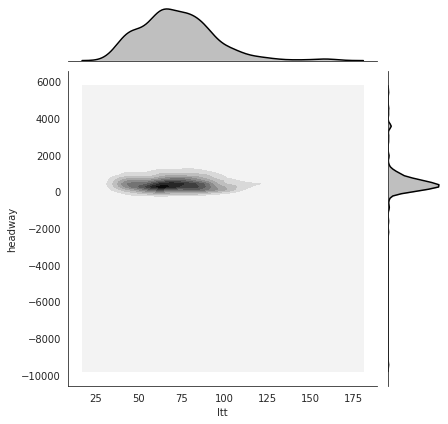

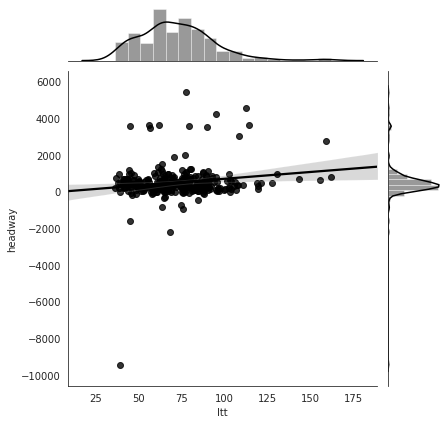

In [136]:
c = df[(df['hour'] == 18) & (df['dayweek'] == 0) & (df['link'] == '(14700, 14701)')] #& (routeBetas['aproxlinkstart'].dt.month == 5)
with sns.axes_style("white"):
    sns.jointplot(x=c.ltt, y=c.headway, kind="kde", color="k")
    sns.jointplot(x=c.ltt, y=c.headway, kind="reg", color="k")

In [151]:
routeBetas

20.000678725099647

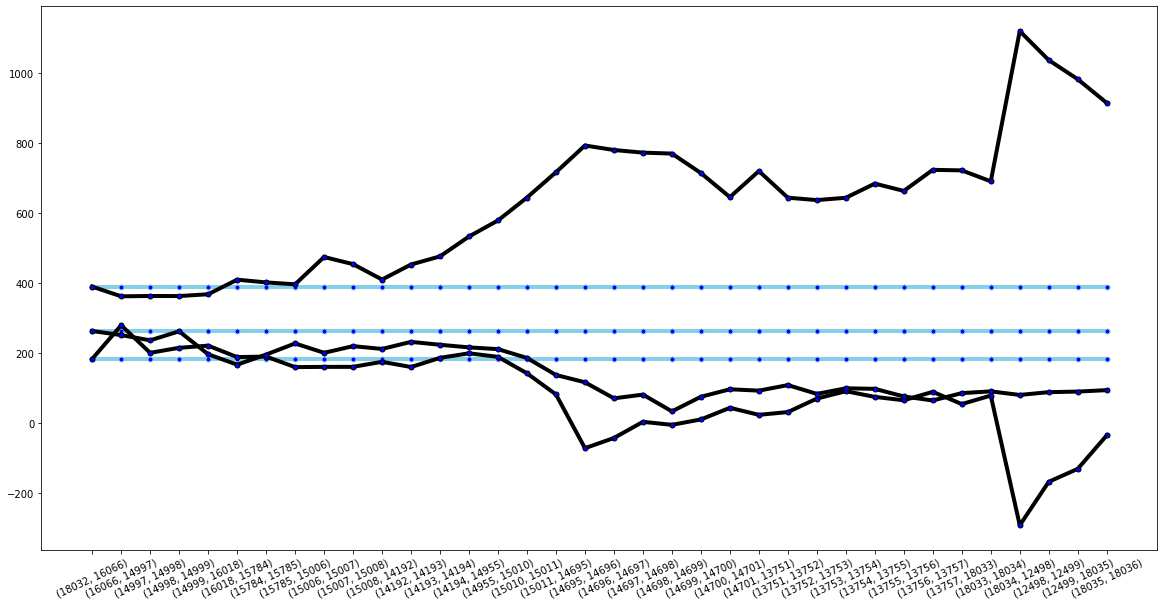

In [172]:
teste208 = routeBetas[routeBetas['travel_id'] == 208]
teste207 = routeBetas[routeBetas['travel_id'] == 207]
teste206 = routeBetas[routeBetas['travel_id'] == 206]

plt.rcParams["figure.figsize"]=20,10
plt.xticks( rotation=25 )
plt.plot( 'link', 'Hplan', data=teste208, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
plt.plot( 'link', 'Hplan', data=teste207, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
plt.plot( 'link', 'Hplan', data=teste206, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
#plt.plot( 'link', 'headway_mean', data=teste, marker='o', markerfacecolor='blue', markersize=5, color='red', linewidth=4)
#plt.plot( 'link', 'headway_median', data=teste, marker='o', markerfacecolor='blue', markersize=5, color='green', linewidth=4)
plt.plot( 'link', 'headway', data=teste208, marker='o', markerfacecolor='blue', markersize=5, color='black', linewidth=4)
plt.plot( 'link', 'headway', data=teste207, marker='o', markerfacecolor='blue', markersize=5, color='black', linewidth=4)
plt.plot( 'link', 'headway', data=teste206, marker='o', markerfacecolor='blue', markersize=5, color='black', linewidth=4)


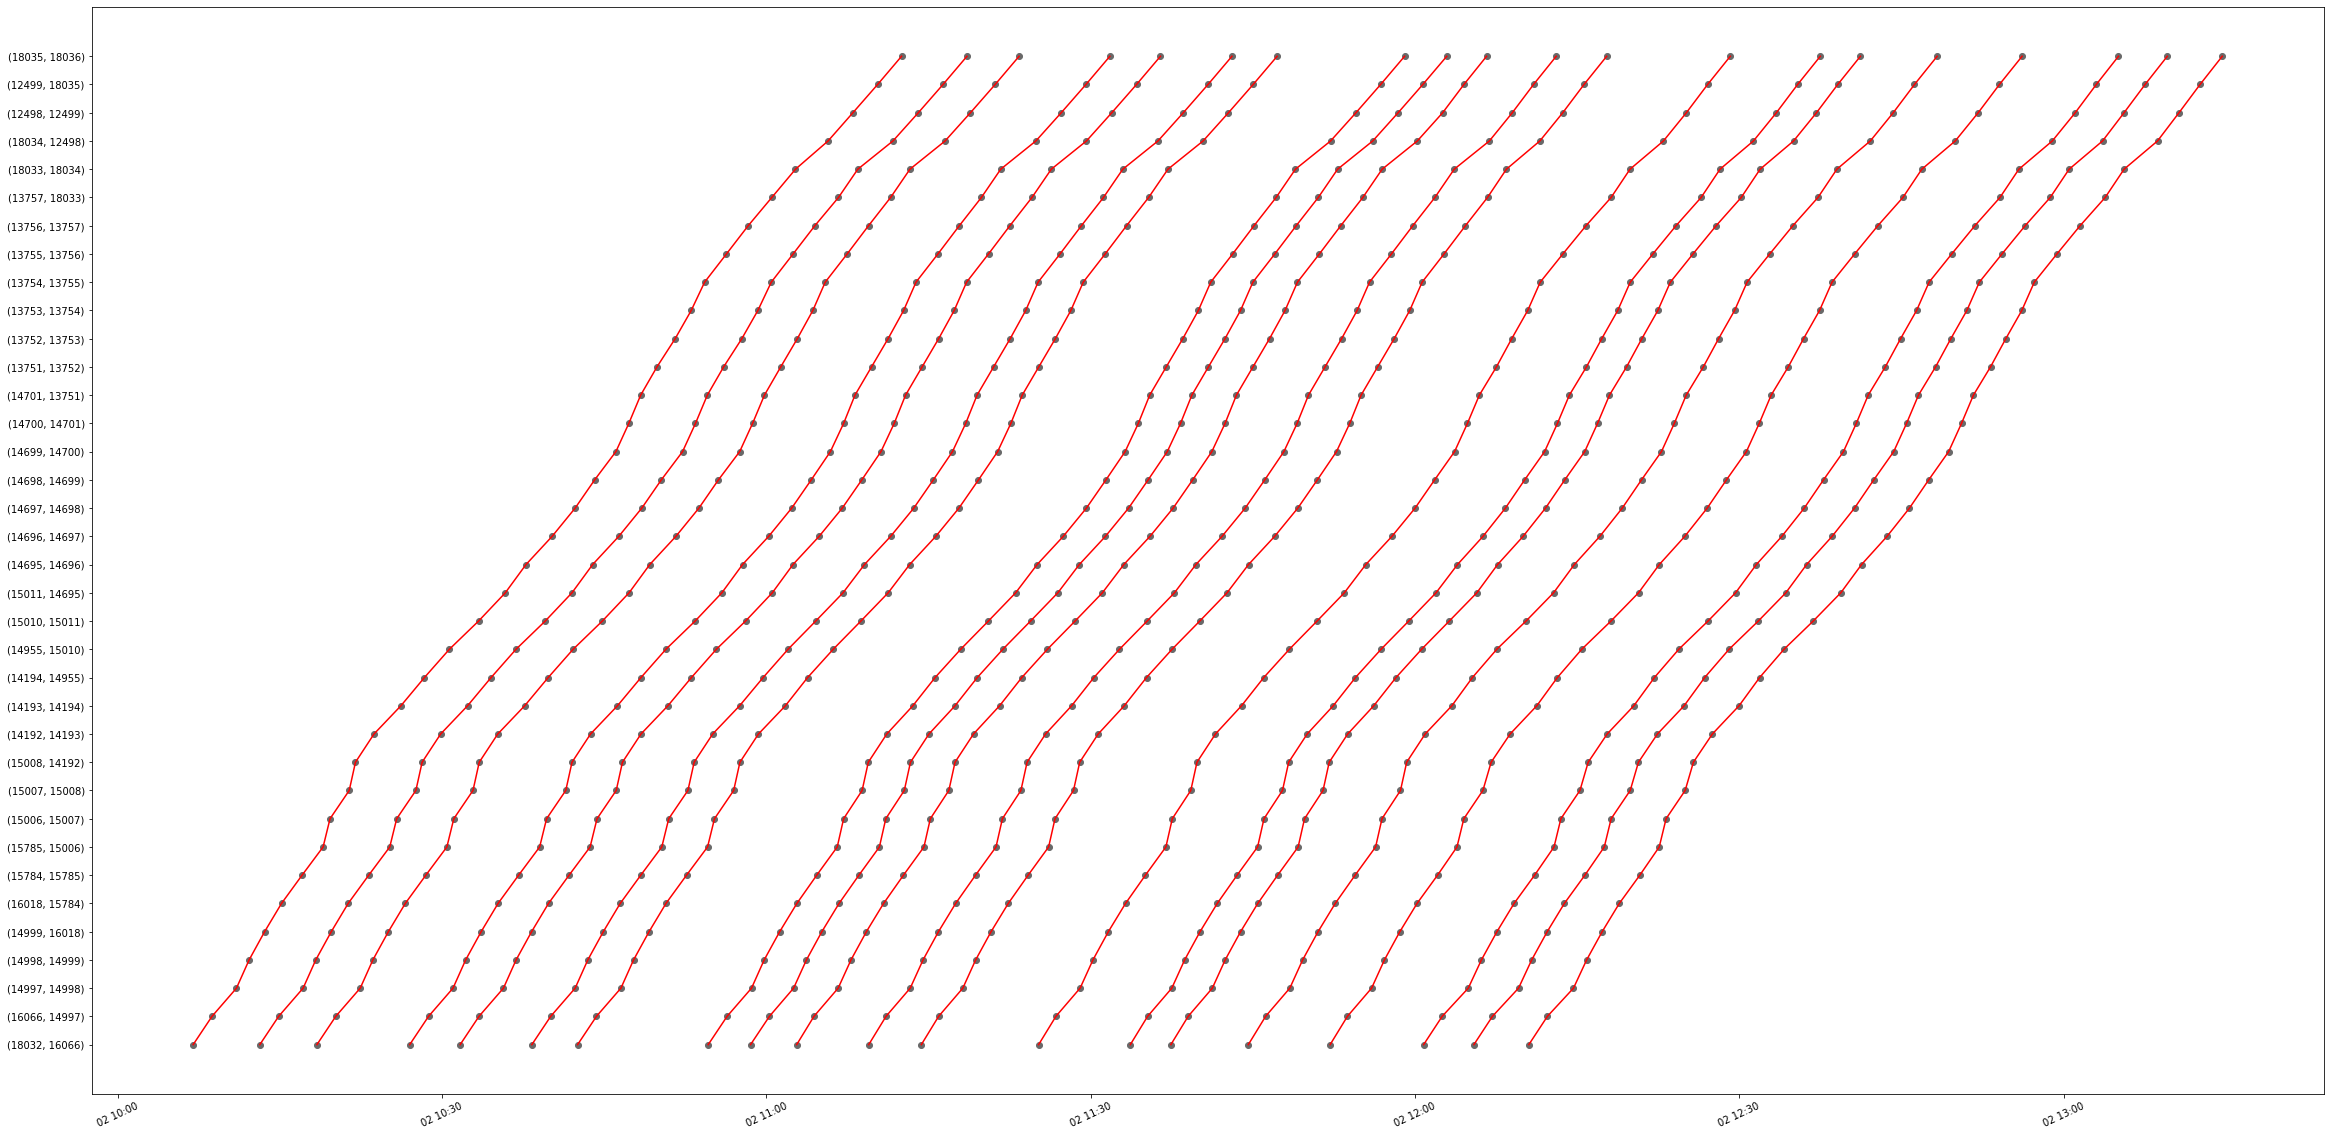

In [178]:
# Plot das viagens da linha 675K
#routeBetas.sort_values(['travel_id','link_id'], axis=0,ascending=True, inplace=True)

plt.rcParams["figure.figsize"]=40,20
plt.xticks( rotation=25 )

for i in range(150,170):
    #plt.plot_date(routeBetas[routeBetas['travel_id'] == i].aproxlinkstart, routeBetas[routeBetas['travel_id'] == i].link, c = 'dimgrey')
    #plt.plot(routeBetas[routeBetas['travel_id'] == i].aproxlinkstart, routeBetas[routeBetas['travel_id'] == i].link, c = 'blue')
    
    #plt.plot_date(routeBetas[routeBetas['travel_id'] == i].ideal_travel_mean, routeBetas[routeBetas['travel_id'] == i].link, c = 'dimgrey')
    #plt.plot(routeBetas[routeBetas['travel_id'] == i].ideal_travel_mean, routeBetas[routeBetas['travel_id'] == i].link, c = 'green')
    
    plt.plot_date(routeBetas[routeBetas['travel_id'] == i].ideal_travel_median, routeBetas[routeBetas['travel_id'] == i].link, c = 'dimgrey')
    plt.plot(routeBetas[routeBetas['travel_id'] == i].ideal_travel_median, routeBetas[routeBetas['travel_id'] == i].link, c = 'red')

plt.show()

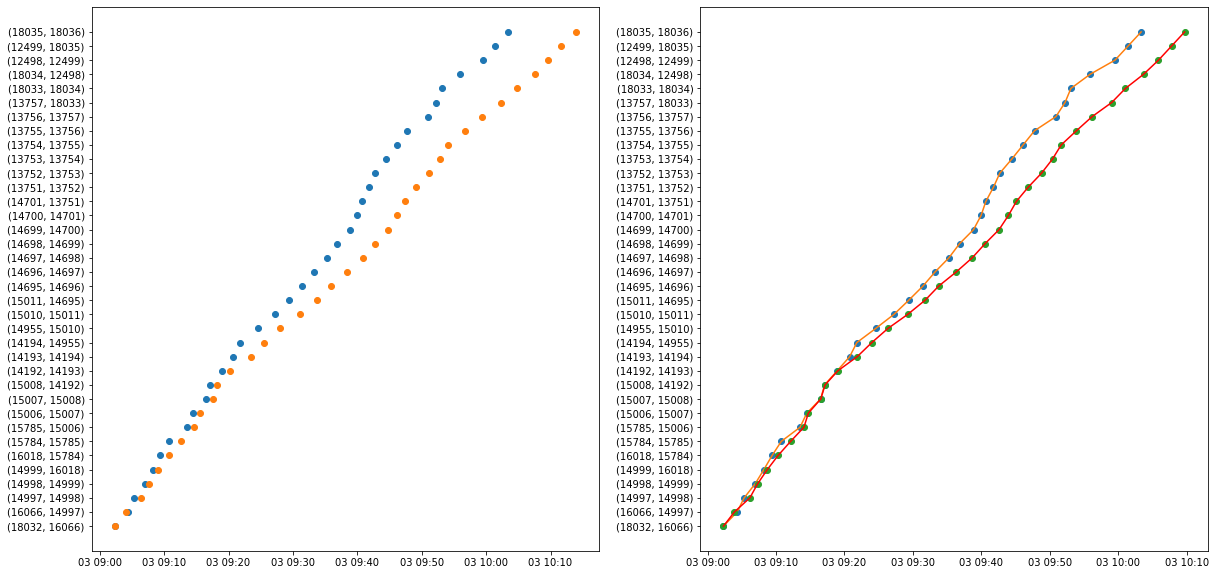

In [209]:
plt.rcParams["figure.figsize"]=20,10

viagem = 300

# One trip vs ideal mean
plt.subplot(1, 2, 1)
plt.plot_date(routeBetas[routeBetas['travel_id'] == viagem].aproxlinkstart, routeBetas[routeBetas['travel_id'] == viagem].link)
#plt.plot(routeBetas[routeBetas['travel_id'] == viagem].aproxlinkstart, routeBetas[routeBetas['travel_id'] == 2].link, )

plt.plot_date(routeBetas[routeBetas['travel_id'] == viagem].ideal_travel_mean, routeBetas[routeBetas['travel_id'] == viagem].link)
#plt.plot(routeBetas[routeBetas['travel_id'] == viagem].ideal_travel_mean, routeBetas[routeBetas['travel_id'] == viagem].link, c = 'green')

# One trip vs ideal median
plt.subplot(1, 2, 2)
plt.plot_date(routeBetas[routeBetas['travel_id'] == viagem].aproxlinkstart, routeBetas[routeBetas['travel_id'] == viagem].link)
plt.plot(routeBetas[routeBetas['travel_id'] == viagem].aproxlinkstart, routeBetas[routeBetas['travel_id'] == viagem].link)

plt.plot_date(routeBetas[routeBetas['travel_id'] == viagem].ideal_travel_median, routeBetas[routeBetas['travel_id'] == viagem].link)
plt.plot(routeBetas[routeBetas['travel_id'] == viagem].ideal_travel_median, routeBetas[routeBetas['travel_id'] == viagem].link, c = 'red')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"]=10,10
for i in range(9,10):
    plt.scatter(routeBetas[(routeBetas['hour'] == i) & (routeBetas['dayweek'] == 1)].headway, routeBetas[(routeBetas['hour'] == i)  & (routeBetas['dayweek'] == 1)].ltt)
    plt.axis([0, 5000, 0, 300])
    plt.show()

In [ ]:
#for i in range(4,10):
plt.rcParams["figure.figsize"]=10,10
plt.scatter(routeBetas[(routeBetas['hour'] == 5) & (routeBetas['dayweek'] == 0)].c_s_hist_mean, routeBetas[(routeBetas['hour'] == 5)  & (routeBetas['dayweek'] == 0)].ltt)
plt.axis([0, 1000, 0, 1000])
plt.show()

3901.64195938929


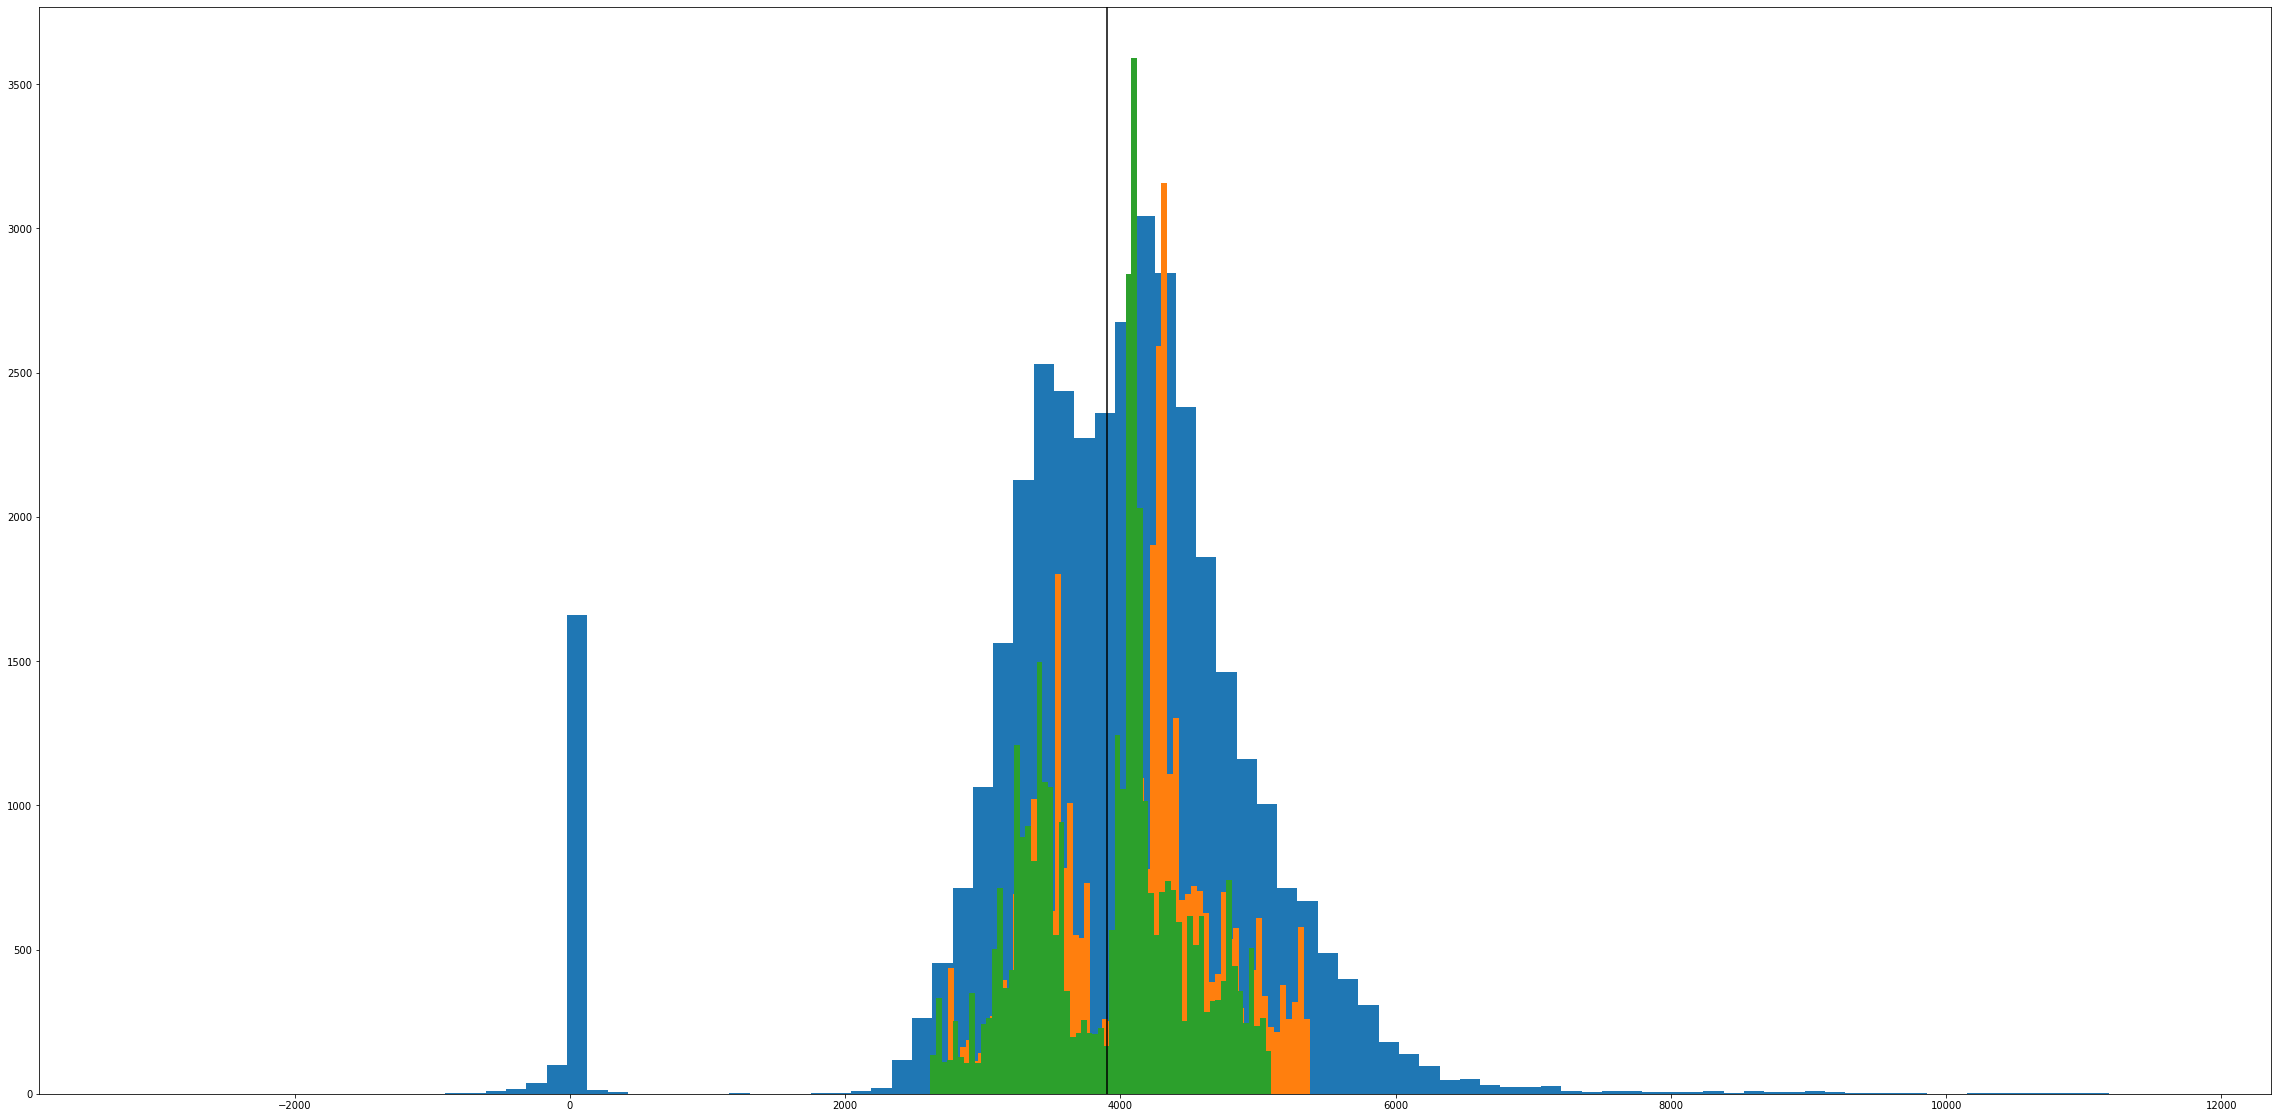

In [193]:
plt.hist(routeBetas[routeBetas['link'] == '(18035, 18036)'].ltt_acc, bins = 100)
plt.hist(routeBetas[routeBetas['link'] == '(18035, 18036)'].c_s_hist_mean_cc, bins = 100)
plt.hist(routeBetas[routeBetas['link'] == '(18035, 18036)'].c_s_hist_median_cc, bins = 100)
plt.axvline(x = routeBetas[routeBetas['link'] == '(18035, 18036)'].ltt_acc.mean(), c = 'k')
print(routeBetas[routeBetas['link'] == '(18035, 18036)'].ltt_acc.mean())
plt.show()

4099.4236436368465
611.1992154615826


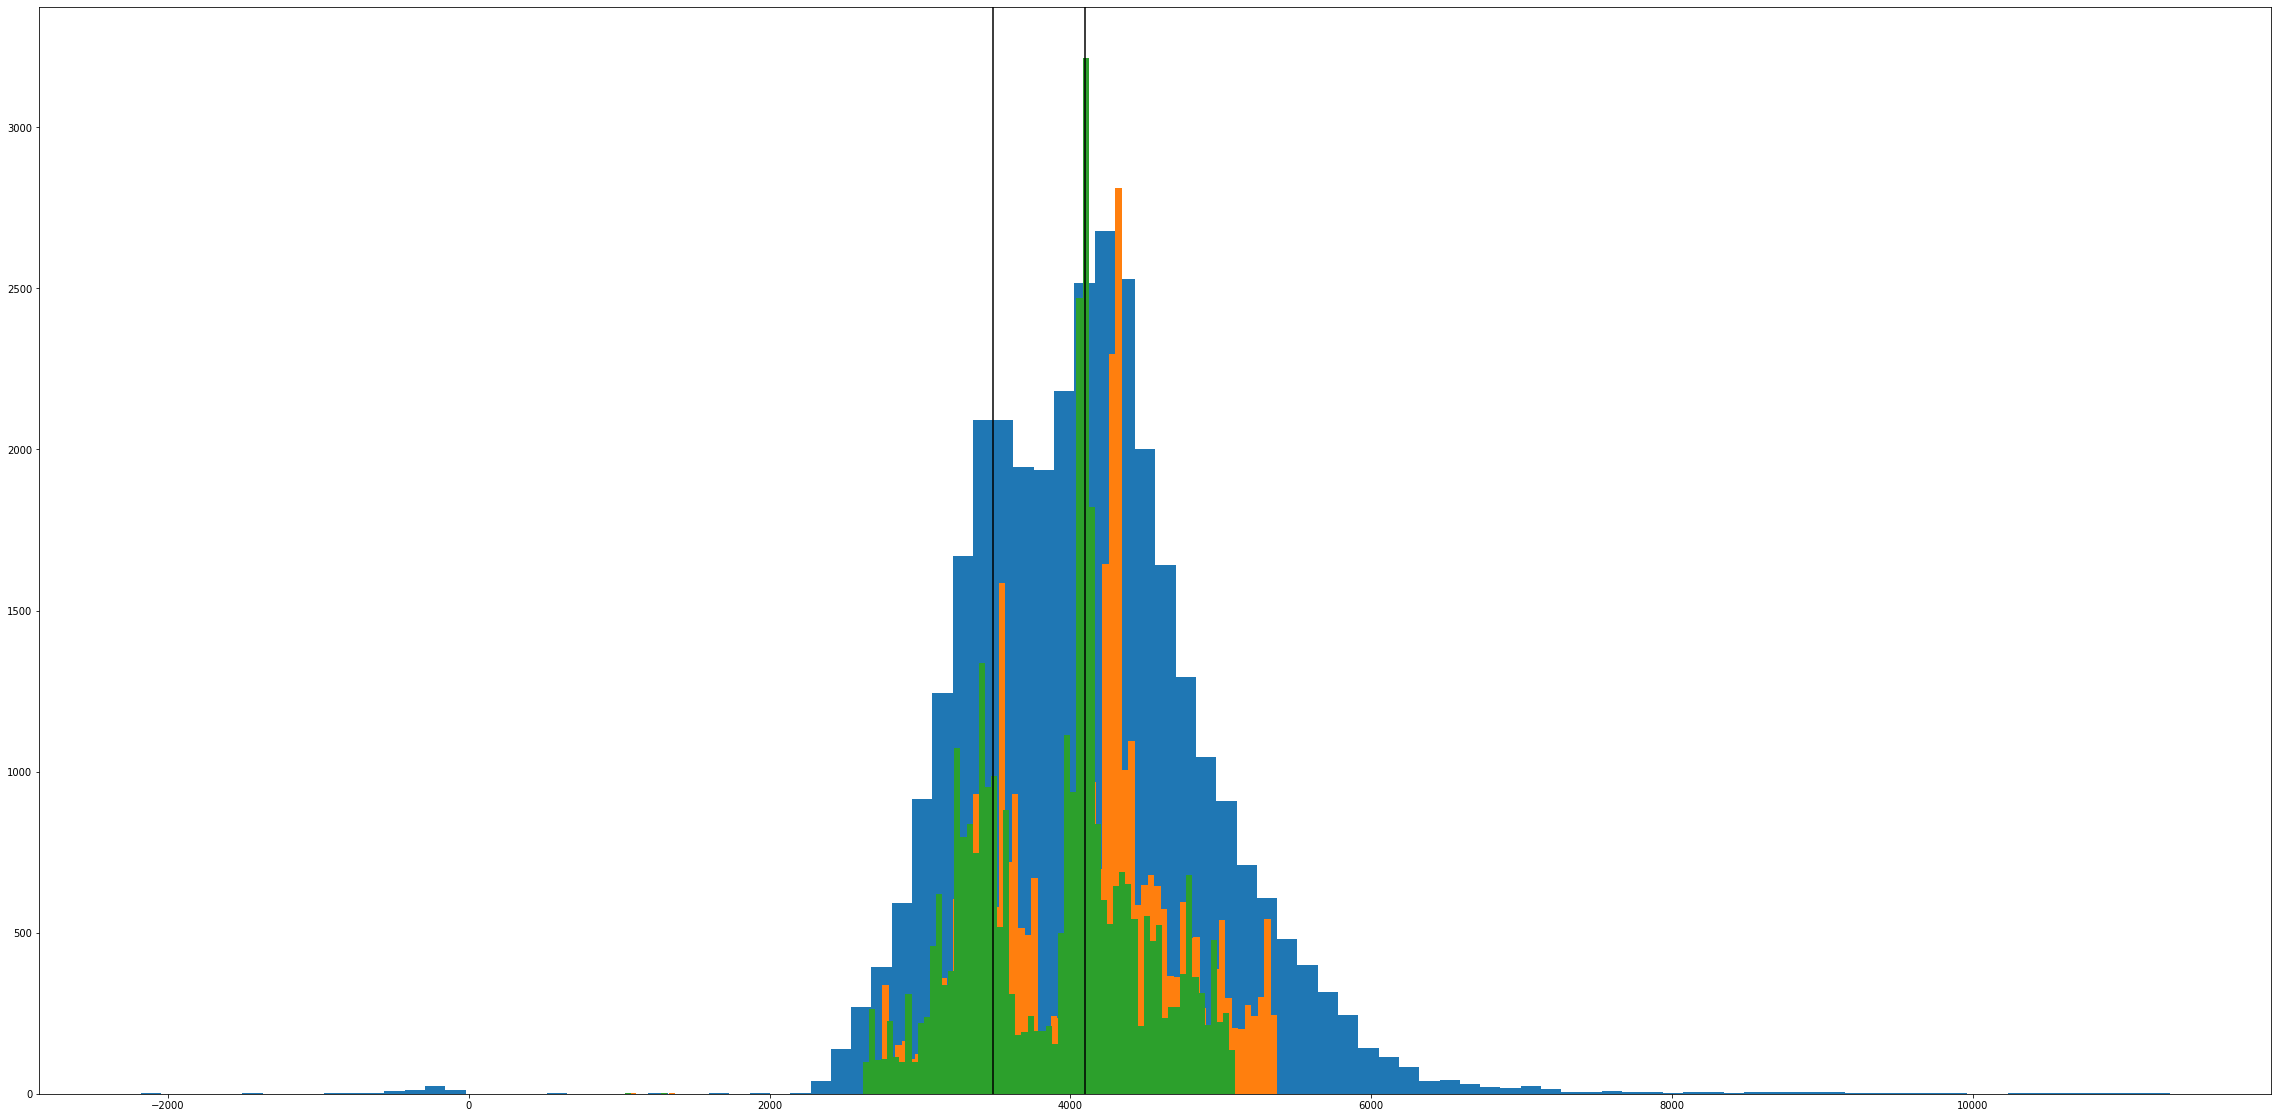

In [201]:
plt.hist(df[df['link'] == '(18035, 18036)'].ltt_acc, bins = 100)
plt.hist(df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc, bins = 100)
plt.hist(df[df['link'] == '(18035, 18036)'].c_s_hist_median_cc, bins = 100)
plt.axvline(x = df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc.mean(), c = 'k')
plt.axvline(x = ((df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc.mean())) - ((df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc.std())), c = 'k')
print(df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc.mean())
print(df[df['link'] == '(18035, 18036)'].c_s_hist_mean_cc.std())
plt.show()

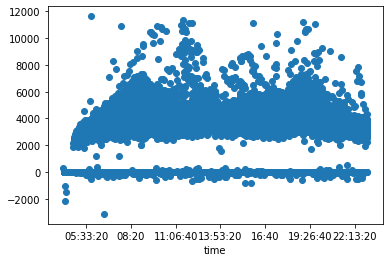

In [255]:
plt.plot_date(routeBetas[routeBetas['link'] == '(18035, 18036)'].aproxlinkstart.dt.time, routeBetas[routeBetas['link'] == '(18035, 18036)'].ltt_acc)

### __Cálculo dos $\beta$__

Nesta parte do código estou incluindo todos os valores necessários para o cálculo do $\beta$. De acordo com o artigo de Daganzo, podemos estimar os valores da constante $\beta$ empiricamente a partir dos logs de tempo-distância dos ônibus.

O $\beta$ é um parâmetro adimensional que expressa o incremento marginal no atraso esperado de um determinado ônibus que surge a partir do incremento em uma unidade de headway, isso porque um longo headway resulta adicionalmente num aumento de pssageiros, o que consequentemente atrasa ainda mais o ônibus. O atraso do ônibus depende quase que totalmente do tempo de embarque de passageiros.

Para o cálculo dos $\beta$ uso a seguinte equação que define a lei de movimento estocástico para um ônibus sem controle:

$a_{n, s + 1} \approx a_{n, s} + U_{n,s} = a_{n, s} + c_{s} + \beta_{s}  (a_{n, s} - a_{n, s + 1} - H) + \nu_{n, s+1}$


Variables:

$a_{n, s + 1}$:

$a_{n, s}$: 

$c_{s}$:

$H$:

$\nu_{n, s+1}$:

1170.0
20.0


In [63]:
# Limpeza da tabela para o cálculo do c_s histórico (por link, por dia da semana, por hora)
routeAdj = routeBetas.copy()
routeAdj.sort_values(['link','aproxlinkstart'], axis=0,ascending=True, inplace=True)
# O intervalo analisado será das 4AM atpe 11PM
routeAdj = routeAdj[~((routeAdj['new_time'] <= datetime.time(4,0,0,0)) | (routeAdj['new_time'] >= datetime.time(23,0,0,0)))]
# Excluímos os feriados, pois entendemos que o comportamento do trânsito nestes dias é diferente
routeAdj = routeAdj[~(routeAdj['new_date'].isin([datetime.date(2017,1,1), datetime.date(2017,1,25), datetime.date(2017,2,27),datetime.date(2017,2,28),
                             datetime.date(2017,3,1), datetime.date(2017,4,14), datetime.date(2017,4,21), datetime.date(2017,5,1),
                             datetime.date(2017,6,15), datetime.date(2017,6,16), datetime.date(2017,7,9), datetime.date(2017,9,7),
                             datetime.date(2017,9,8)]))]
#As viagens entre os links serão de no mínimo 20s e no máximo 900s
routeAdj = routeAdj[((routeAdj['ltt'] >= 20) & (routeAdj['ltt'] <= 1170))]
# As viagens com velocidades abaixo de 3km/h ou acima de 70km/h - este intervalo exclui 0.14% dos dados
routeAdj = routeAdj[((routeAdj['speed'] >= 3) & (routeAdj['speed'] <= 70))]

110.26291361705314
109.14960686700863


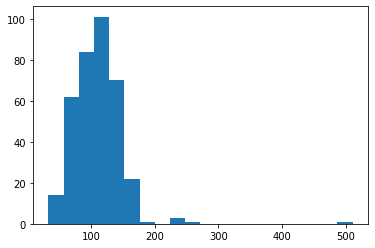

108.64804863330043
105.70028099488525


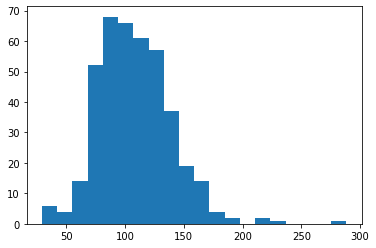

112.4300768061461
111.77650558982572


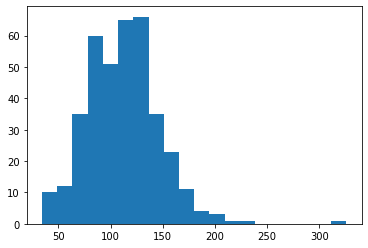

113.22400649593472
110.13446678032136


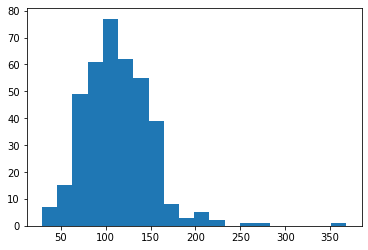

108.40741331189629
106.41716632664293


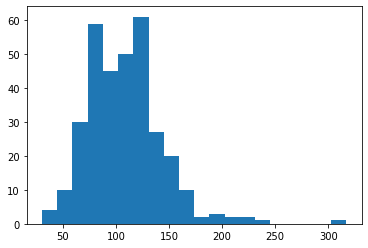

90.0156629497224
84.51731969988873


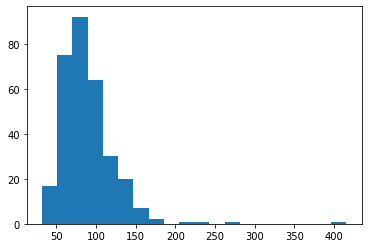

82.45630499701566
79.14961043288102


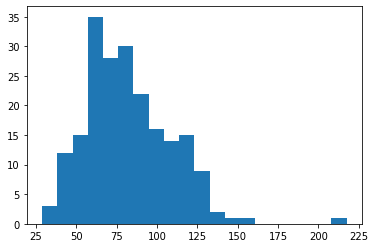

In [461]:
#plt.hist(routeAdj.speed, bins = 50)
#plt.show()
for i in range(7):
    plt.hist(routeAdj[(routeAdj['dayweek']==i) & (routeAdj['hour']==5) & (routeAdj['link']=='(15784, 15785)')].ltt, bins = 20)
    print(routeAdj[(routeAdj['dayweek']==i) & (routeAdj['hour']==5) & (routeAdj['link']=='(15784, 15785)')].ltt.mean())
    print(routeAdj[(routeAdj['dayweek']==i) & (routeAdj['hour']==5) & (routeAdj['link']=='(15784, 15785)')].ltt.median())
    plt.show()
#sns.kdeplot(routeAdj.ltt,shade=True, color="r")
#routeAdj[(routeAdj['speed'] > 70) & (routeAdj['link'] == '(12499, 18035)')]
#routeAdj.info()

In [207]:
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt

(array([ 2.,  4.,  7.,  7., 15., 49., 53., 45., 47., 32., 19., 18.,  8.,
         1.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([3.47192124, 3.59980923, 3.72769722, 3.85558521, 3.9834732 ,
        4.11136119, 4.23924918, 4.36713717, 4.49502516, 4.62291315,
        4.75080114, 4.87868913, 5.00657712, 5.13446511, 5.2623531 ,
        5.39024109, 5.51812908, 5.64601707, 5.77390507, 5.90179306,
        6.02968105]),
 <a list of 20 Patch objects>)

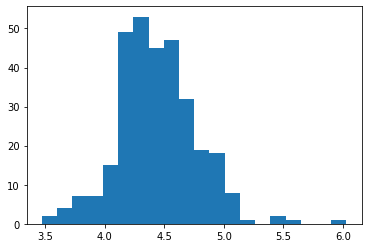

In [472]:
from scipy.stats import boxcox

plt.hist(boxcox(routeAdj[(routeAdj['dayweek']==5) & (routeAdj['hour']==5) & (routeAdj['link']=='(15784, 15785)')].ltt,0), bins = 20)

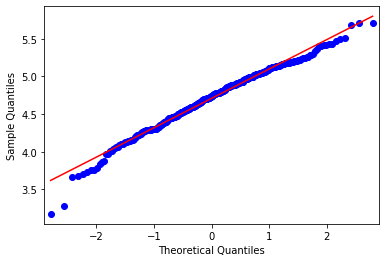

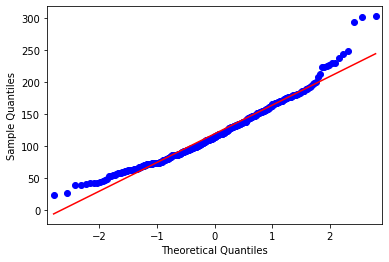

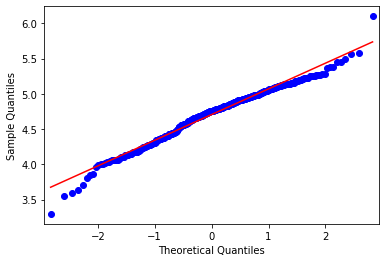

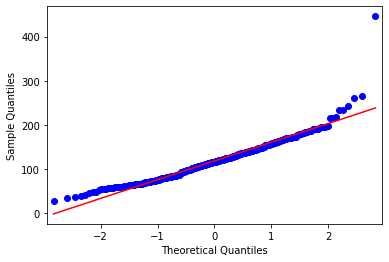

In [547]:
for i in range(2):
    qqplot(boxcox(routeAdj[(routeAdj['dayweek']==i) & (routeAdj['hour']==5) & (routeAdj['link']=='(16066, 14997)')].ltt,0, alpha = 0.95), line='s')
    qqplot(routeAdj[(routeAdj['dayweek']==i) & (routeAdj['hour']==5) & (routeAdj['link']=='(16066, 14997)')].ltt, line='s')
    pyplot.show()
#qqplot(routeAdj.speed, stats.lognorm.ppf(0.01, 0.954), line='s')
#pyplot.show()

Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=8620.099, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 144.995
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
Sample does not look Lognormal (reject H0)


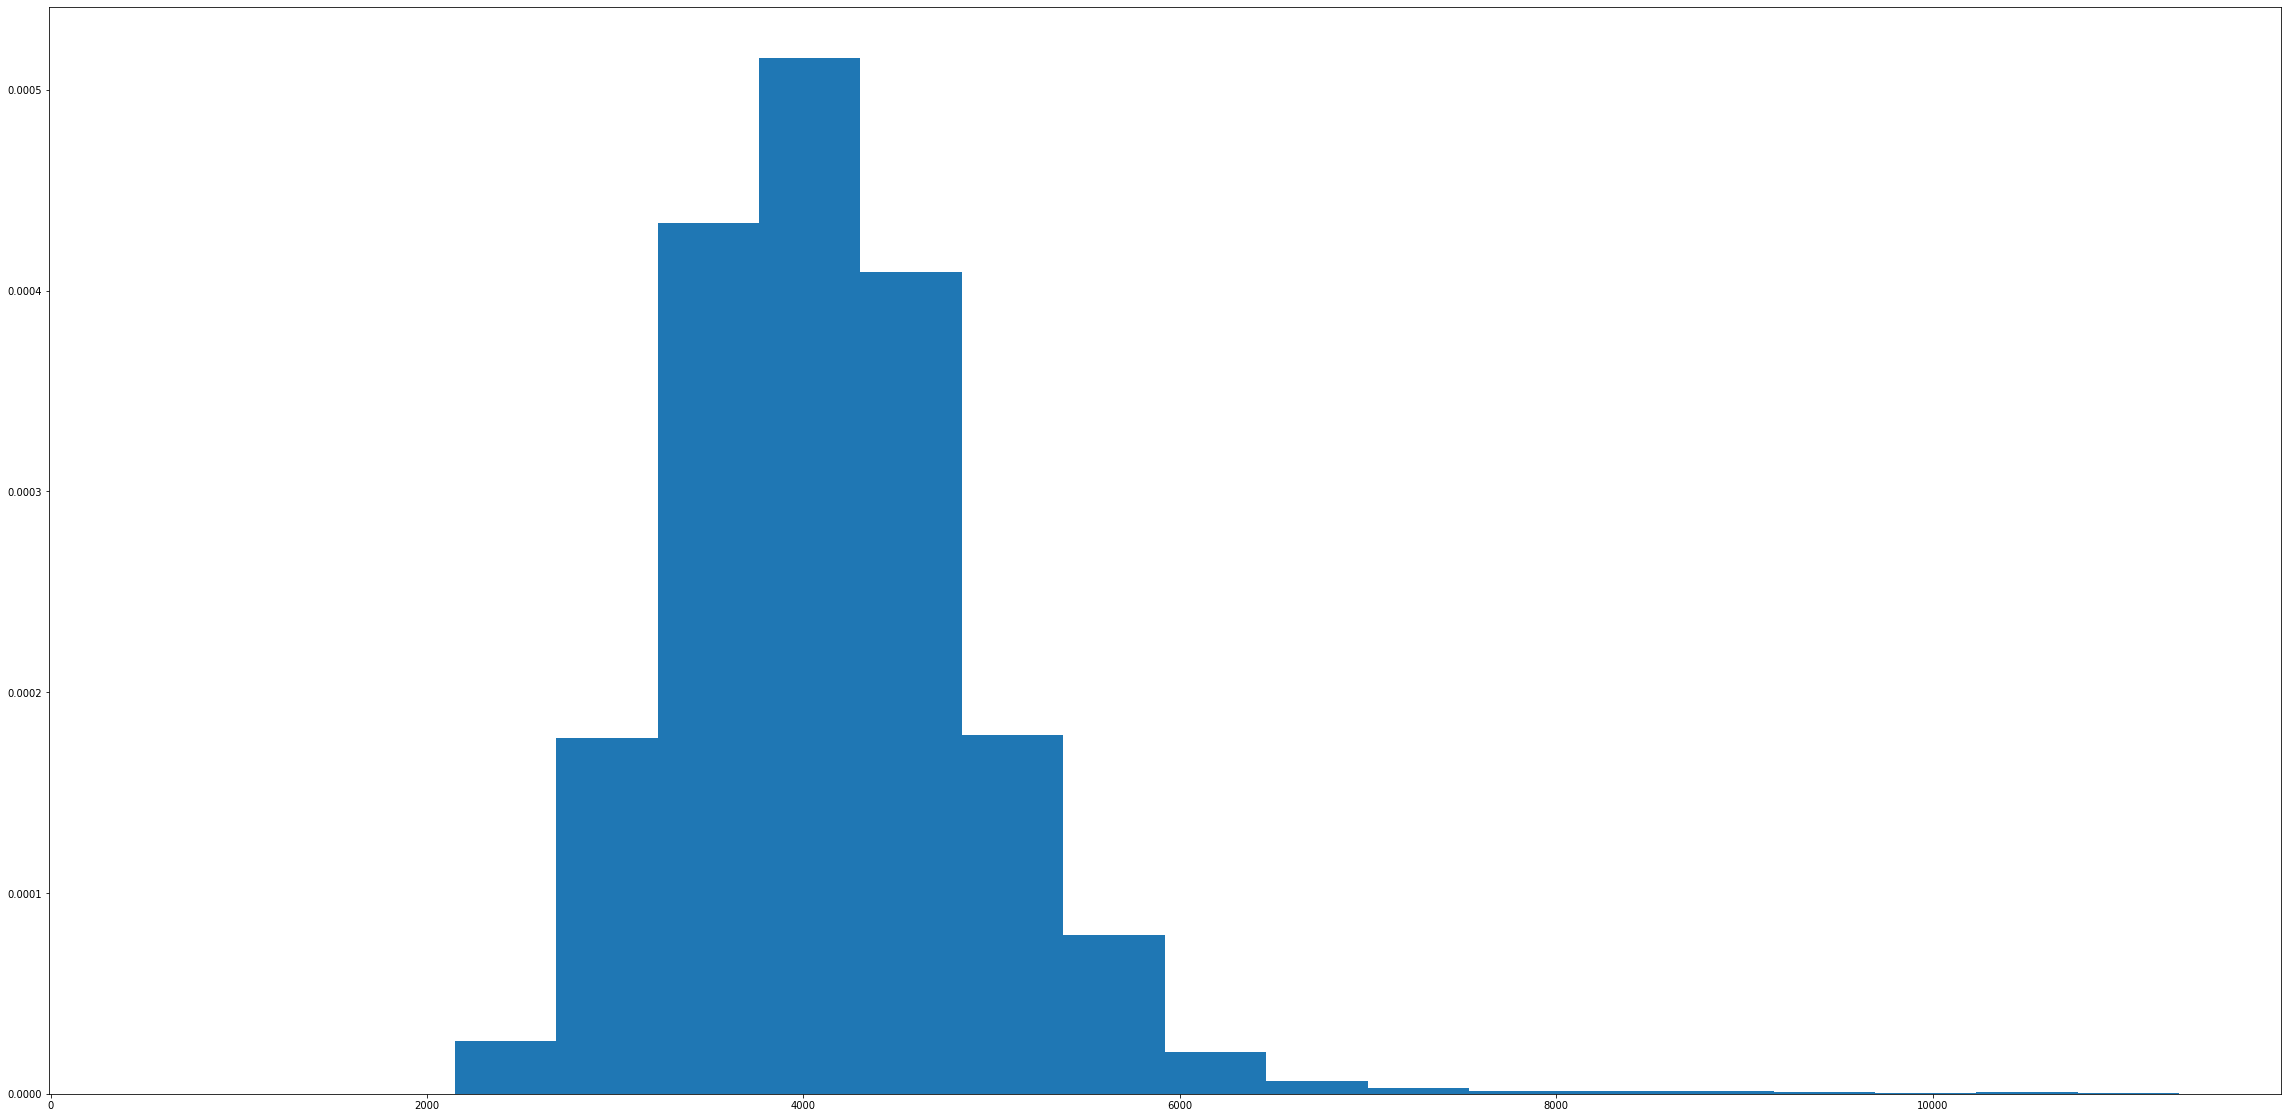

In [208]:
# Testes de nromalidade das colunas
from scipy.stats import boxcox
#Teste com transformação lognormal nos dados de ltt
#a = boxcox(routeAdj[(routeAdj['dayweek']==0) & (routeAdj['hour']==22) & (routeAdj['link']=='(18032, 16066)')].ltt,0, alpha = 0.95)
a = df[(df['link'] == '(18035, 18036)') & (df['ltt_acc'] > 0)].ltt_acc
from scipy.stats import shapiro
#Shapiro-Wilk Test
# normality test
stat, p = shapiro(a)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

#D’Agostino’s K^2 Test
from scipy.stats import normaltest
stat, p = normaltest(a)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

#Anderson-Darling Test
from scipy.stats import anderson
result = anderson(a, dist = 'norm')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        
#Kolmogorov-Smirnov test
from scipy.stats import kstest
from scipy.stats import weibull_min
from scipy.stats import alpha
from scipy.stats import betaprime
from scipy.stats import burr
from scipy.stats import exponnorm
from scipy.stats import f
from scipy.stats import gamma
#print(kstest(routeAdj.speed,'lognorm'))
count, bins, ignored = plt.hist(a, 20, density=True, align='mid')
params = stats.lognorm.fit(count)
stat, p = stats.kstest(count, "lognorm", params)
alpha = 0.05
if p > alpha:
    print('Sample looks Lognormal (fail to reject H0)')
else:
    print('Sample does not look Lognormal (reject H0)')
    
# Para o ltt os testes de normalidade rejeitam a hipótese nula (os dados proveem de uma distribuição normal).
# Opção 1: fazer transformações para normalizar os dados
# ou usar métodos de estatística não paramétricas

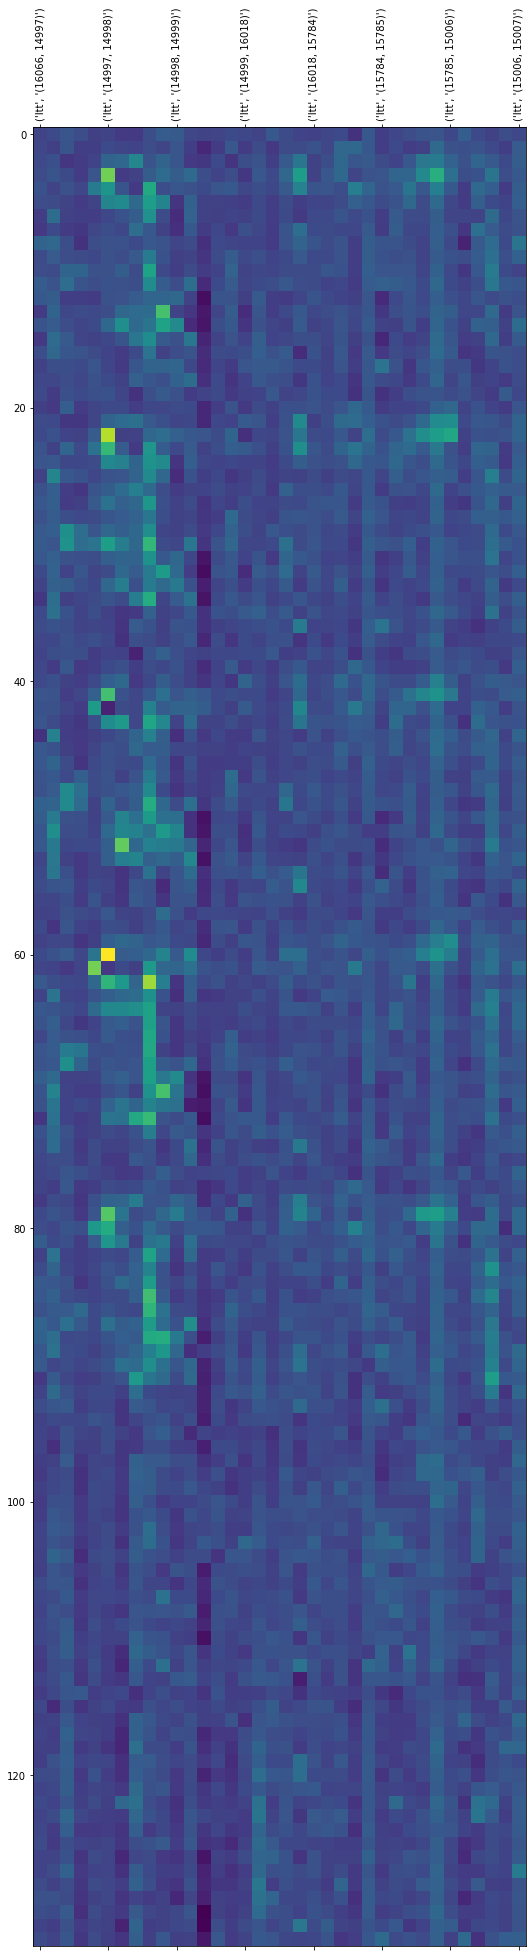

In [74]:
#Heatmap da diferença da média e mediana
a = route_mean - route_median
a[cols]

import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
%matplotlib inline


gs = gridspec.GridSpec(1, 3)
pl.figure(figsize=(30,100))
ax = pl.subplot(gs[0, 0])
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation='vertical')
ax.matshow(a)

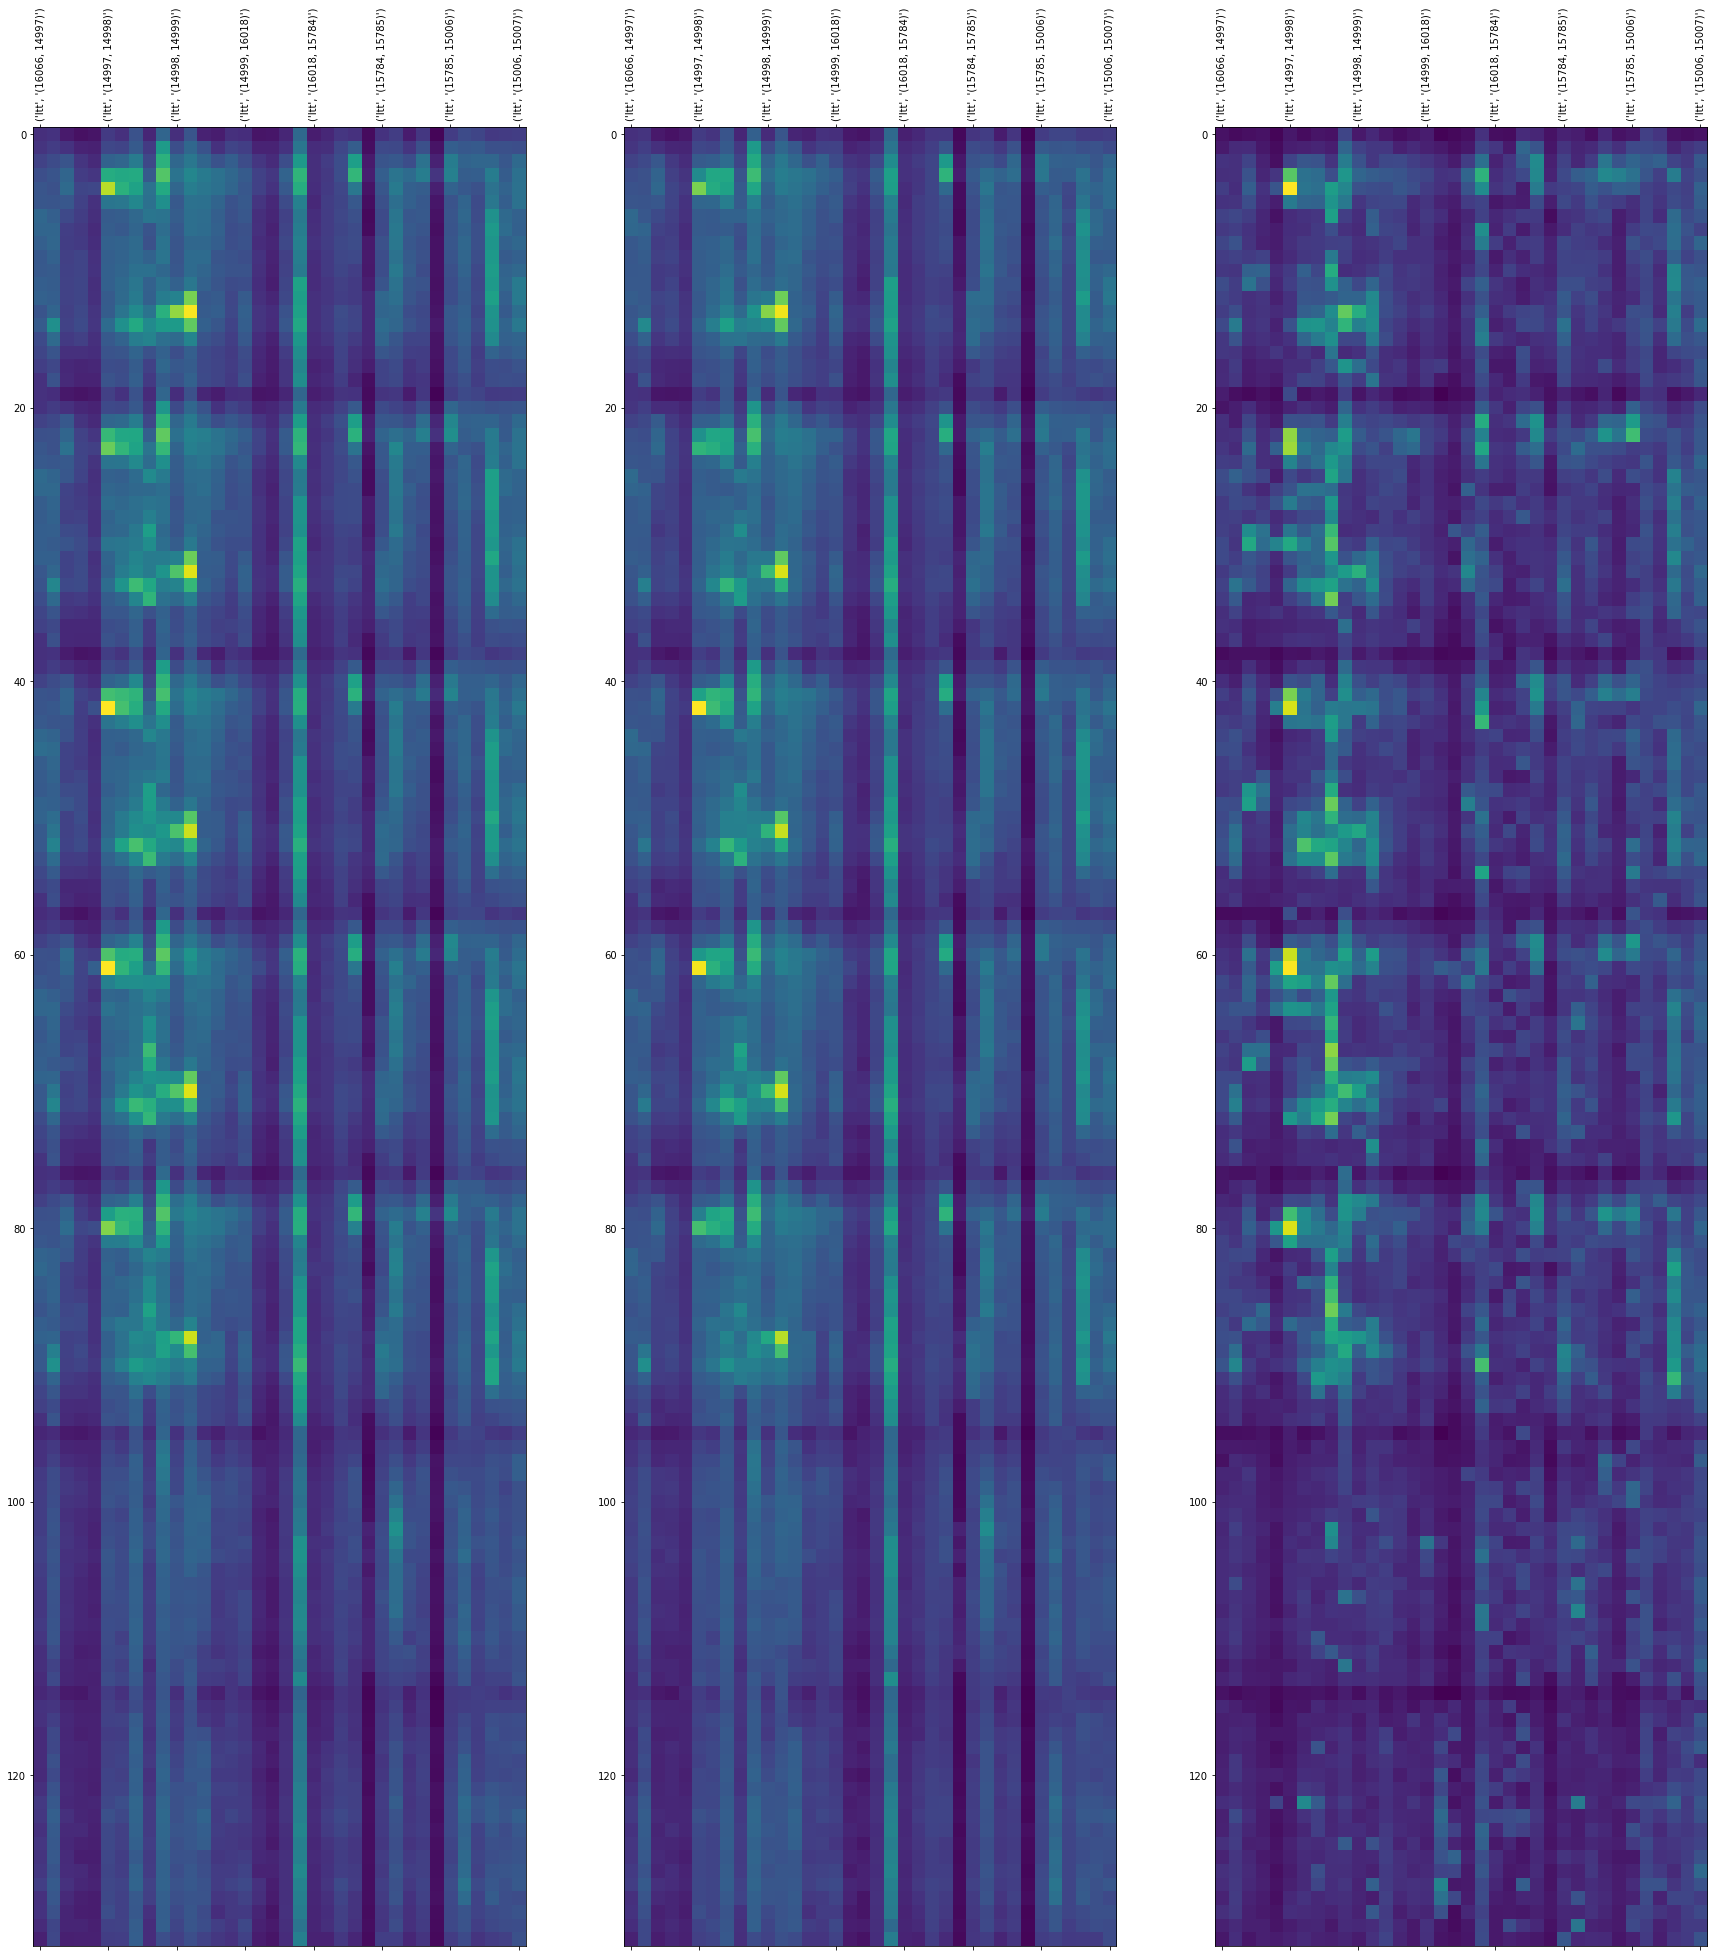

In [75]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
%matplotlib inline

gs = gridspec.GridSpec(1, 3)
pl.figure(figsize=(30,100))

#plot das médias
ax = pl.subplot(gs[0, 0])
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation='vertical')
ax.matshow(route_mean)

#plot das medianas
ax = pl.subplot(gs[0, 1])
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation='vertical')
ax.matshow(route_median)

#plot dos desvios
ax = pl.subplot(gs[0, 2])
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation='vertical')
ax.matshow(route_std)

In [169]:
routeBetas = route.copy()
routeBetas = routeBetas[~((routeBetas['new_time'] <= datetime.time(4,0,0,0)) | (routeBetas['new_time'] >= datetime.time(23,0,0,0)))]
routeBetas['hour'] = [d.hour for d in routeBetas['aproxlinkstart']]

In [638]:
routeBetas.drop(['c_s_hist_mean','c_s_hist_median','c_s_hist_std','coef_var','c_s_hist_mean_cc','c_s_hist_median_cc'], axis = 1, inplace = True)

In [80]:
# Inserção dos c_s_hist_mean
c_s = []
for index, row in routeBetas.iterrows():
    c_s.append((route_mean.loc[(row['dayweek'],row['hour'])][('ltt', row['link'])]))
    
routeBetas['c_s_hist_mean'] = c_s
#routeBetas.rename(columns={'c_s_hist':'c_s_hist_mean'},inplace=True)

In [83]:
# Inserção dos c_s_hist_median
c_s_med = []
for index, row in routeBetas.iterrows():
    c_s_med.append((route_median.loc[(row['dayweek'],row['hour'])][('ltt', row['link'])]))
    
routeBetas['c_s_hist_median'] = c_s_med

In [84]:
# Inserção do std
c_s_std = []
for index, row in routeBetas.iterrows():
    c_s_std.append((route_std.loc[(row['dayweek'],row['hour'])][('ltt', row['link'])]))
    
routeBetas['c_s_hist_std'] = c_s_std

In [186]:
# Coeficiente de variação
routeBetas['coef_var'] = routeBetas['c_s_hist_std'] / routeBetas['c_s_hist_mean']

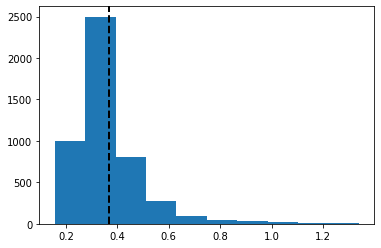

0.36889341335271736

In [197]:
plt.hist(routeBetas['coef_var'].unique())
plt.axvline(routeBetas['coef_var'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()
routeBetas['coef_var'].mean()

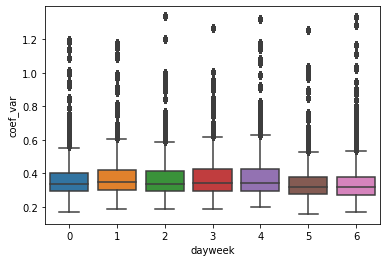

In [199]:
sns.boxplot(x=routeBetas['dayweek'], y=routeBetas['coef_var'])

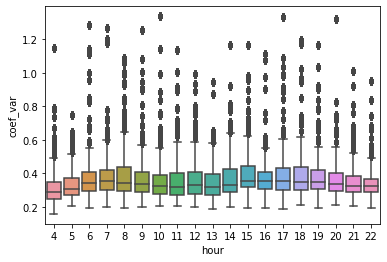

In [200]:
sns.boxplot(x=routeBetas['hour'], y=routeBetas['coef_var'])

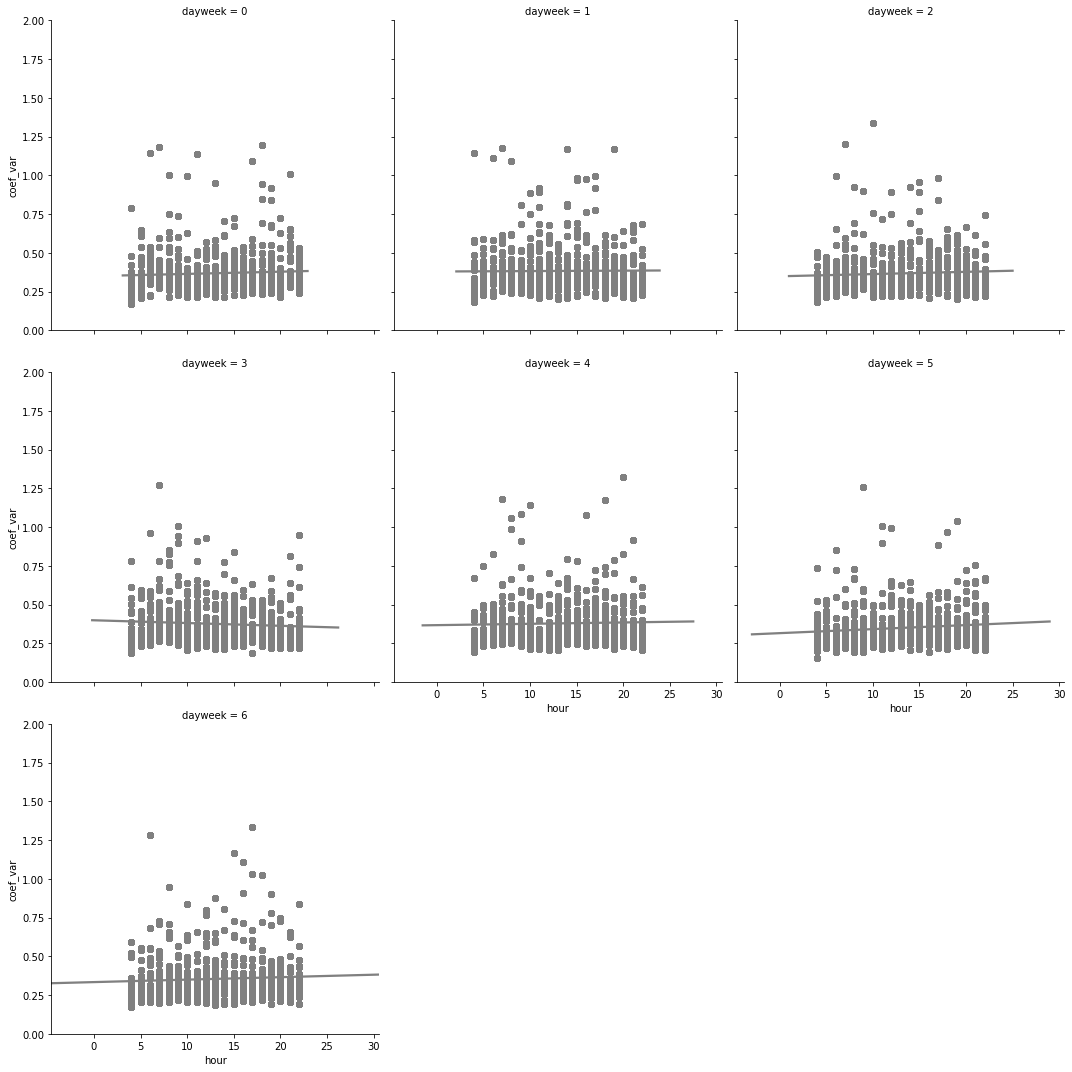

In [242]:
g = sns.FacetGrid(routeBetas, col="dayweek", col_wrap=3, height=5, ylim=(0, 2))
g.map(sns.regplot, "hour", "coef_var", color=".5", ci=None);
#sns.pointplot

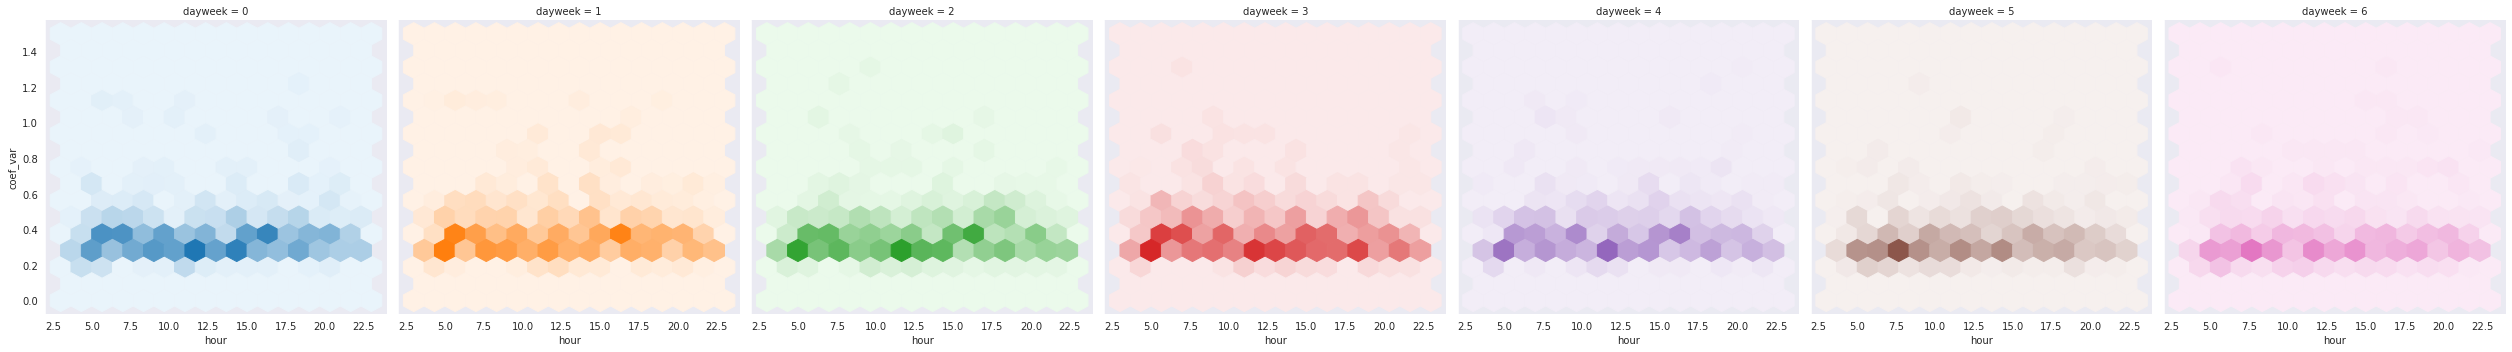

In [234]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(routeBetas, hue="dayweek", col="dayweek", height=5)
g.map(hexbin, "hour", "coef_var",extent=[3, 23, 0, 1.5]);

In [169]:
# mergeando os valores de distância para cada link
routeBetas = pd.merge(routeBetas, infra, on='link')

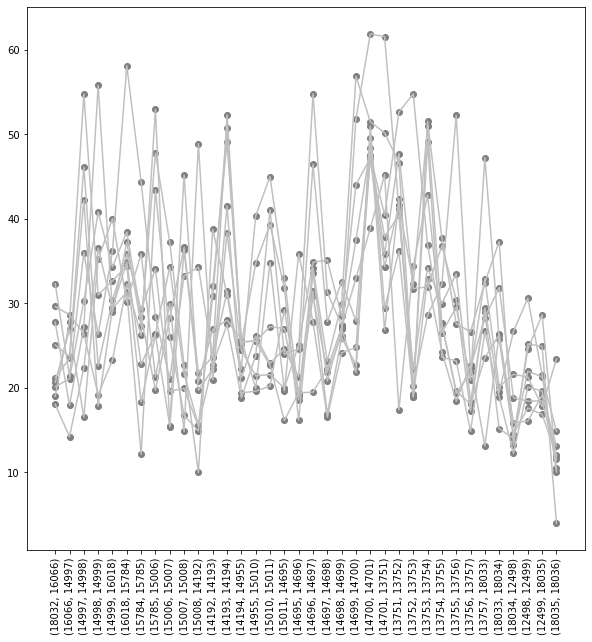

In [682]:
#routeBetas.sort_values(['aproxlinkstart', 'link'], axis = 0, ascending = True, inplace = True)
plt.rcParams["figure.figsize"]=10,10

for i in range(1,10):
    plt.scatter(routeBetas[routeBetas['travel_id'] == i].link,routeBetas[routeBetas['travel_id'] == i].speed, c = 'grey')
    plt.plot(routeBetas[routeBetas['travel_id'] == i].link,routeBetas[routeBetas['travel_id'] == i].speed, c = 'silver')

plt.xticks(rotation=90)
plt.show()

In [836]:
#tempo = routeBetas[['travel_id','ltt','link_id']].copy()
#tempo.sort_values(['travel_id', 'link_id'], axis = 0, ascending = True, inplace = True)
#tempo.drop(['link_id'], axis = 1, inplace = True)
#tempo2 = tempo.groupby('travel_id').cumsum()

#tempo3 = tempo2.values.tolist()
#routeBetas.sort_values(['travel_id', 'link_id'], axis = 0, ascending = True, inplace = True)
routeBetas.drop(['ltt_acc'], axis = 1, inplace = True)
routeBetas['ltt_acc'] = flat_list

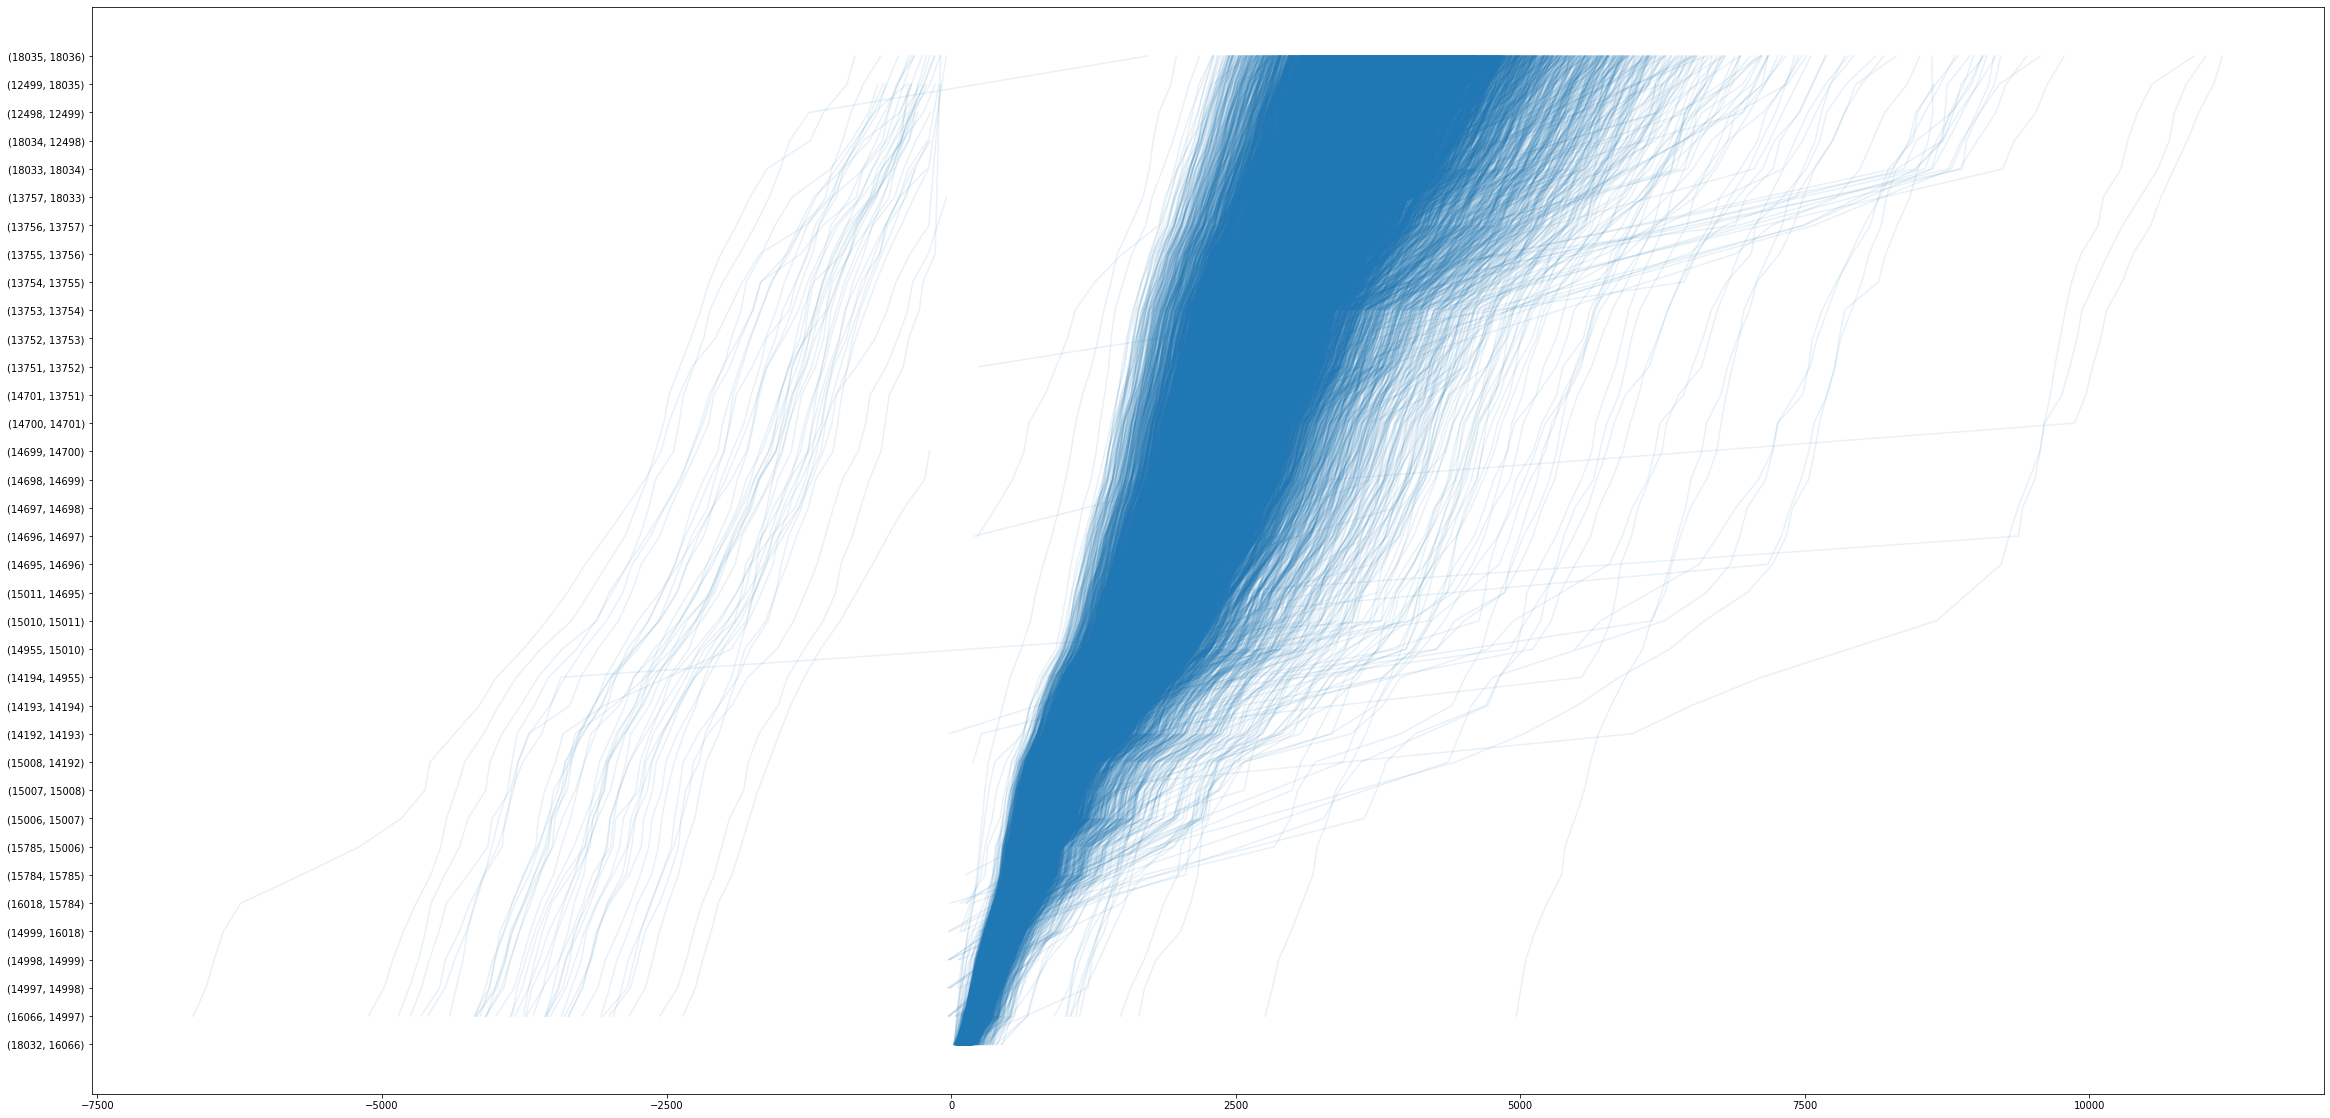

In [153]:
plt.rcParams["figure.figsize"]=40,20

for i in range(1,10000):
    #plt.scatter(routeBetas[routeBetas['travel_id'] == i].ltt_acc, routeBetas[routeBetas['travel_id'] == i].link, c = 'grey')
    plt.plot(df[df['travel_id'] == i].ltt_acc, df[df['travel_id'] == i].link, c = 'C0', alpha = 0.1)

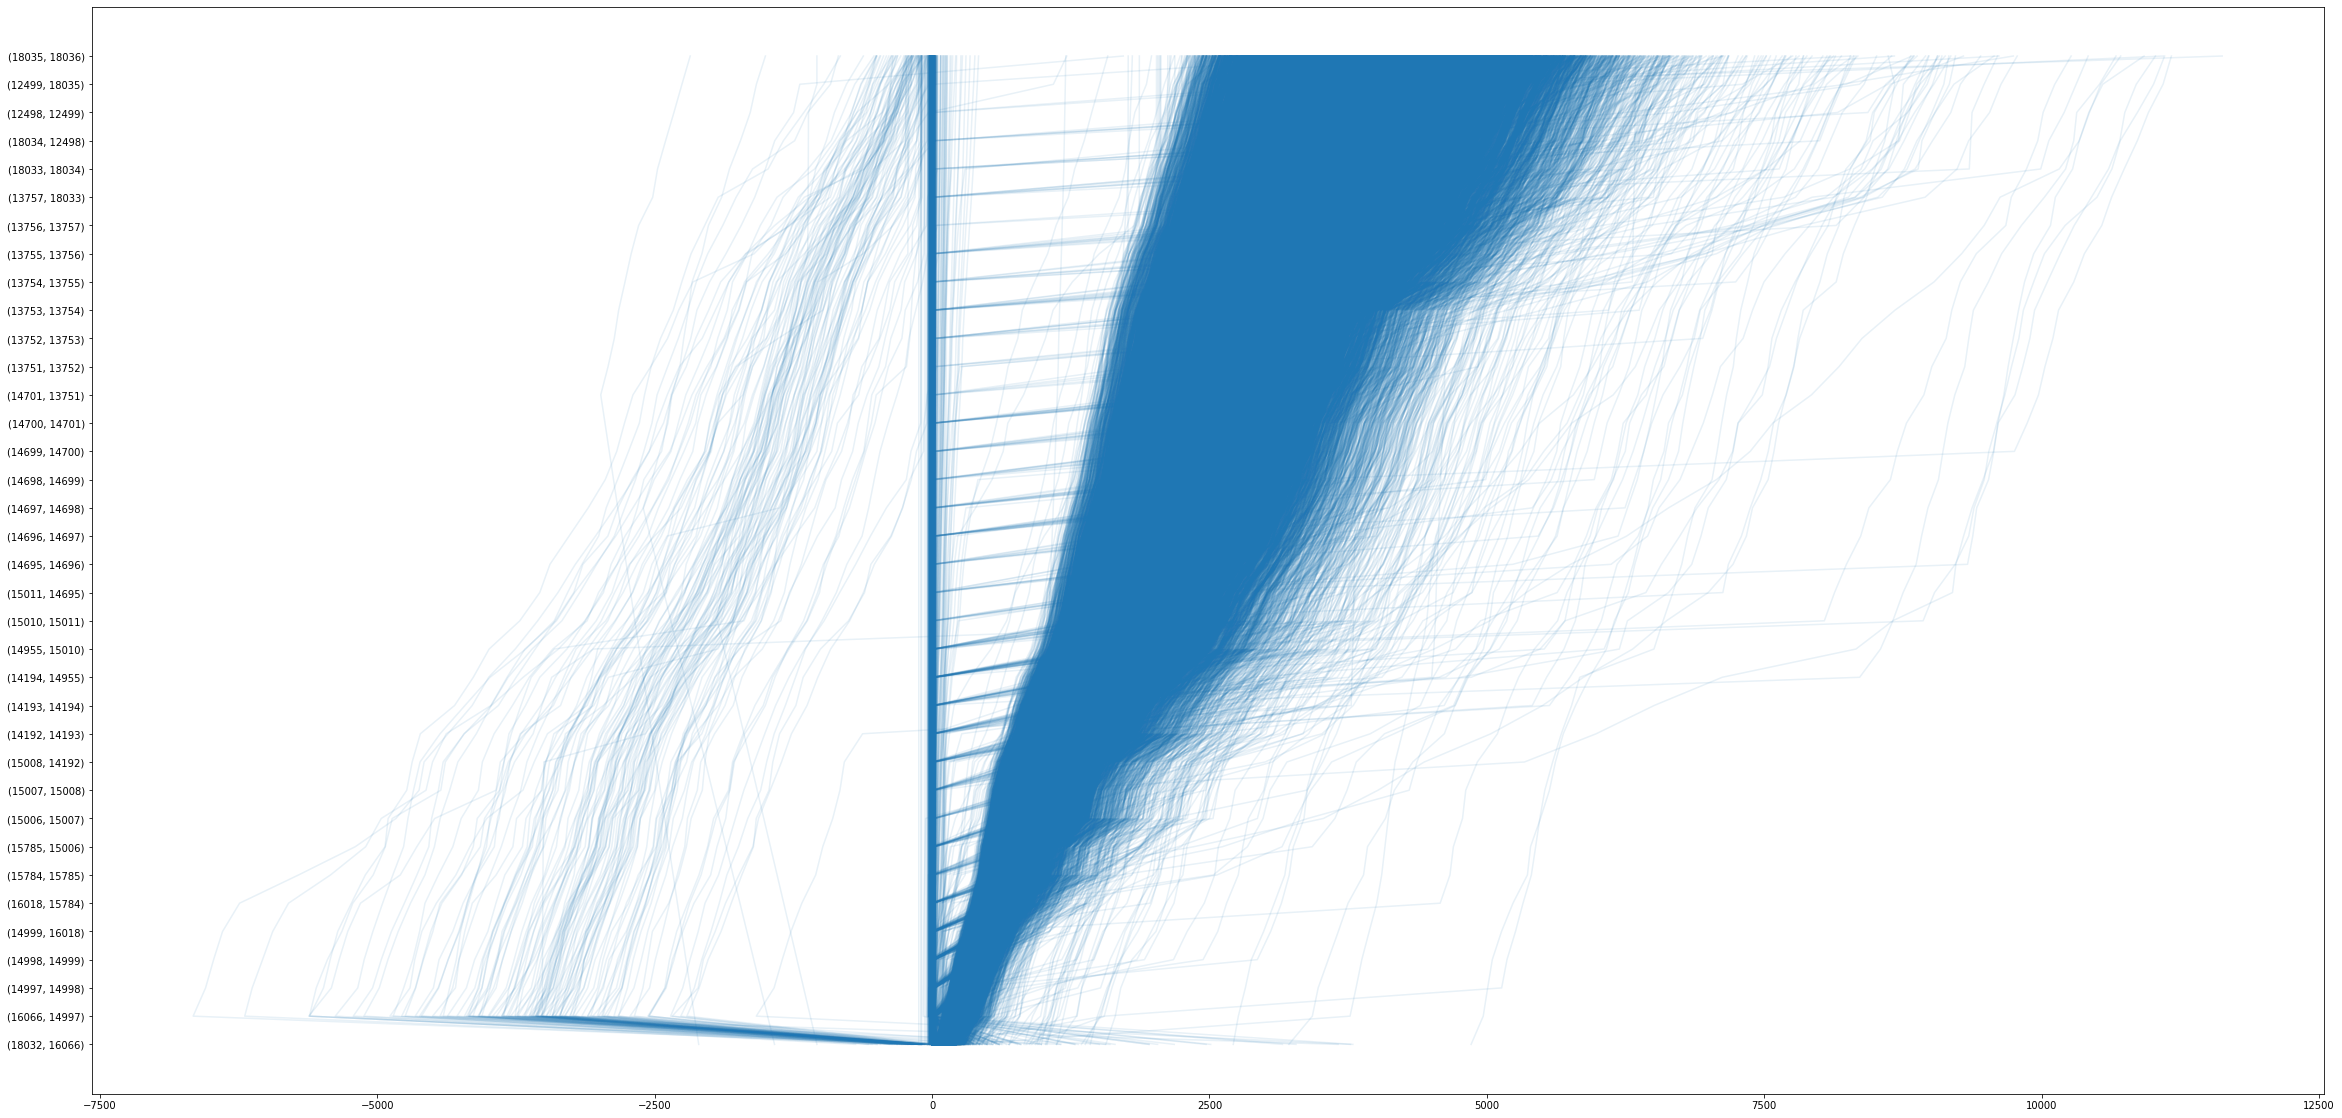

In [82]:
plt.rcParams["figure.figsize"]=40,20

for i in range(1,30000):
    #plt.scatter(routeBetas[routeBetas['travel_id'] == i].ltt_acc, routeBetas[routeBetas['travel_id'] == i].link, c = 'grey')
    plt.plot(routeBetas[routeBetas['travel_id'] == i].ltt_acc, routeBetas[routeBetas['travel_id'] == i].link, c = 'C0', alpha = 0.1)


In [ ]:
hd = []
for index, row in route.iterrows():
    if ((row['link'] == '(18032, 16066)') & (row['travel_id'] in mini)):
        hd.append(0)
    else:
        hd.append(row['headway']) 

In [24]:
numerator_hist = []
for index, row in routeBetas.iterrows():
    numerator_hist.append(row['ltt'] - row['c_s_hist'])

routeBetas['numerator_hist'] = numerator_hist

denominator_hist = []
for index, row in routeBetas.iterrows():
    denominator_hist.append(row['headway'] - row['Hplan'])
    
routeBetas['denominator_hist'] = denominator_hist

beta_hist = []
for index, row in routeBetas.iterrows():
    if row['denominator_hist'] == 0:
        beta_hist.append(0)
    else:
        beta_hist.append(row['numerator_hist'] / row['denominator_hist'])

routeBetas['beta_hist'] = beta_hist

routeBetas_hist = routeBetas[routeBetas['beta_hist'] != 0]

In [17]:
#routeBetas['accum'].append(routeBetas['ltt'].cumsum())
#routeBetas[routeBetas['travel_id'] == 2]

lnk = ['(18032, 16066)','(16066, 14997)', '(14997, 14998)']
trvl = [1]


dic = {'travel_id': [1,1,1], 'link': ['(18032, 16066)','(16066, 14997)', '(14997, 14998)'], 'ltt': [1,2,3]}
df = pd.DataFrame(dic)

lista1 = []
for i in trvl:
    lista2 = []
    for j in lnk:
        if j in lista2:
            lista2.append(df.ltt + df.ltt.shift())
        else:
            lista2.append(df.ltt.value())
    lista1.append(lista2)

lista1

AttributeError: 'Series' object has no attribute 'value'

In [32]:
routeBetas_hist = routeBetas[routeBetas['beta_hist'] != 0]

In [94]:
a = routeBetas[(routeBetas['link'] == '(18032, 16066)')]


In [62]:
a = routeBetas_hist[(routeBetas_hist['hour'] == 9) & (routeBetas_hist['dayweek']== 1) & (routeBetas_hist['link'] == '(12498, 12499)')]

In [63]:
a = a[a['beta_hist'] > -100]

In [64]:
a['beta_hist'].min()

-13.790728138245191

### __Limpeza da base de dados__

In [108]:
route = route[~(route['new_date'].isin([datetime.date(2017,1,1), datetime.date(2017,1,25), datetime.date(2017,2,27),datetime.date(2017,2,28),
                             datetime.date(2017,3,1), datetime.date(2017,4,14), datetime.date(2017,4,21), datetime.date(2017,5,1),
                             datetime.date(2017,6,15), datetime.date(2017,6,16), datetime.date(2017,7,9), datetime.date(2017,9,7),
                             datetime.date(2017,9,8)]))]
route = route[~((route['new_time'] <= datetime.time(4,0,0,0)) | (route['new_time'] >= datetime.time(22,0,0,0)))]

#route_adj = route[((route['ltt'] >= 20) & (route['ltt'] <= 700))]

# extrair os Hs reais no primeiro link
routeH = route.copy()[route['link'] == '(18032, 16066)']
routeH['Hplan'] = (routeH['aproxlinkstart'] - routeH['aproxlinkstart'].shift()).dt.total_seconds()

# Excluir a primeira tupla
# viagens < 36

In [ ]:
# extrair os Hs reais no primeiro link
routeH = route.copy()[route['link'] == '(18032, 16066)']
routeH['Hplan'] = (routeH['aproxlinkstart'] - routeH['aproxlinkstart'].shift()).dt.total_seconds()

In [109]:
routeHplan = routeH[['travel_id','aproxlinkstart', 'dayweek', 'new_time','Hplan']]
#routeHplan.describe() 35971 dados
routeHplan = routeHplan[((routeHplan['Hplan'] >= 30) & (routeHplan['Hplan'] <= 900))]
plt.hist(routeHplan['Hplan'], bins = 10)
plt.axvline(routeHplan['Hplan'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(routeHplan['Hplan'].median(), color='b', linestyle='dashed', linewidth=2)
plt.show()
print("Média: ", routeHplan['Hplan'].mean(), ' | ',"Desvio Padrão: ",routeHplan['Hplan'].std(), ' | ',"Mediana: ",routeHplan['Hplan'].median())

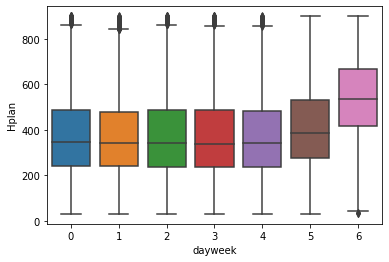

In [175]:
#plt.boxplot(routeHplan['Hplan'])
#plt.show()
ax = sns.boxplot(x=routeHplan['dayweek'], y=routeHplan['Hplan'])

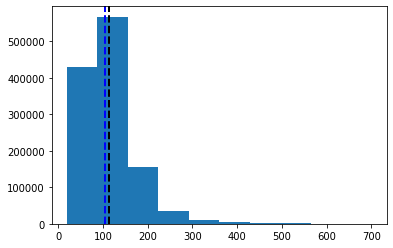

Média:  114.56543995972733  |  Desvio Padrão:  60.73419424282447  |  Mediana:  104.05667081483261


In [176]:
# o corte foi realizado pegando o menor link e multiplicando pela velocidade 50km/h e o maior link pela velocidade de 5km/h
route = route[((route['ltt'] >= 20) & (route['ltt'] <= 700))]
histr = route.nlargest(50, ['ltt'])
plt.hist(route['ltt'], bins = 10)
plt.axvline(route['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(route['ltt'].median(), color='b', linestyle='dashed', linewidth=2)
plt.show()
print("Média: ", route['ltt'].mean(), ' | ',"Desvio Padrão: ",route['ltt'].std(), ' | ',"Mediana: ",route['ltt'].median())

In [199]:
routeHplan['hour'] = routeHplan['aproxlinkstart'].dt.hour
routeHplan.head()

travel_id      aproxlinkstart  dayweek  new_time  Hplan  hour
3353         95 2017-01-02 04:16:22        0  04:16:22  400.0     4
3362         96 2017-01-02 04:20:41        0  04:20:41  259.0     4
3376         97 2017-01-02 04:26:30        0  04:26:30  349.0     4
3399         98 2017-01-02 04:33:07        0  04:33:07  397.0     4
3411         99 2017-01-02 04:36:33        0  04:36:33  206.0     4

In [214]:
#for i in mid_points:
#for i in range(4,22):
#route_mean.head(18)

#for link in mid_points:
#    for i in range(7):
#        for j in range(4,22):
#            print(route_mean.loc[(link, i, j),:]['ltt'])
route['hour'] = route['aproxlinkstart'].dt.hour

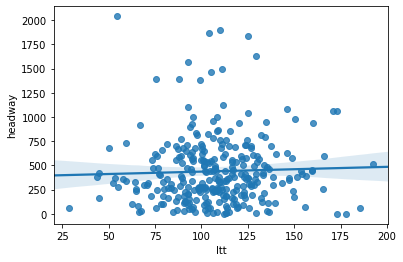

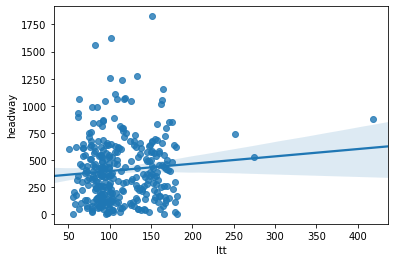

In [255]:
teste_sp = route[(route['hour']== 12) & (route['link'] == '(14697, 14698)') & (route['dayweek']== 1)]
teste_sp = teste_sp[((teste_sp['ltt'] >= 20) & (teste_sp['ltt'] <= 700))]
sns.regplot(teste_sp['ltt'], teste_sp['headway'])
plt.show()

teste_sp = route[(route['hour']== 13) & (route['link'] == '(14697, 14698)') & (route['dayweek']== 1)]
teste_sp = teste_sp[((teste_sp['ltt'] >= 20) & (teste_sp['ltt'] <= 700))]
sns.regplot(teste_sp['ltt'], teste_sp['headway'])
plt.show()

In [237]:
teste_sp['ltt'].max()

312.00698770454983

In [130]:
mid_points

NameError: name 'mid_points' is not defined

In [790]:
route_std.loc[('(12498, 12499)', 6),:]

ltt     travel_id      headway
aproxlinkstart                                      
4               17.242833  10701.578054   460.905845
5               27.812333  11223.240324  6723.331613
6               23.221064  10724.823050  2082.553417
7               23.428492  10973.755080   368.481202
8               22.803589  10932.415914   459.370004
9               23.746501  10856.815790   449.247029
10              25.147626  11137.547497   434.362324
11              24.756435  10739.298269   471.455029
12              30.008601  11300.315654   437.901544
13              23.663284  10879.544139   484.852220
14              24.446015  10535.647812   572.663335
15              31.416356  11097.716861   501.504229
16              25.354990  10887.164723   521.069374
17              31.275458  11001.282759   570.216026
18              29.589486  10824.551880   531.207304
19              25.045086  11090.867034   589.156599
20              30.556047  10743.155160   574.163847
21              23.873492  11224.819235   566.383113

In [561]:
route_f = route_in.loc['(18032, 16066)'].dropna()
route_g = route_f.groupby(['link', pd.Grouper(key = 'aproxlinkstart',freq='H')])['ltt'].mean()
route_g
#df.groupby(['name', pd.Grouper(key='date', freq='M')])['ext price'].sum()

KeyError: 'link'

In [513]:
route_grouped.head()

ltt  travel_id  headway
link           dayweek aproxlinkstart                                        
(12498, 12499) 0       2017-01-02 04:49:25.591  94.630066       94.0    0.077
                       2017-01-02 04:54:58.950  75.734139       95.0   34.760
                       2017-01-02 05:07:58.230  67.605478       97.0   22.547
                       2017-01-02 05:15:44.035  54.250813       98.0   16.558
                       2017-01-02 05:16:01.731  71.301719       99.0    7.248

In [527]:
route_g.iloc[0,2]

15.401446153846157

In [502]:
route_grouped = route_grouped.groupby([pd.Grouper(freq='H', level=-1)])

AttributeError: Cannot access callable attribute 'groupby' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [468]:
route_grouped.loc['(12498, 12499)']

ltt     travel_id    headway
dayweek                                     
0        109.745959  19617.669438  11.475082
1        111.047540  19494.484521  15.216139
2        113.979932  20249.124768  11.407463
3        111.853367  19004.206664  11.583102
4        111.328949  19510.243592  11.446517
5         81.926496  20116.156678  12.816368
6         74.269938  19432.529730  18.195003

In [365]:
teste = route[route['link'] == '(18032, 16066)']
teste2 = teste[teste['headway']>=600]
#teste2['headway'].min()


In [366]:
teste2['new_date'].nunique()

245

In [370]:
duplicate = teste2[teste2.duplicated(['new_date'])]
duplicate

_id      aproxlinkstart            link  \
339458  5c76efc0bd8143570ffe684d 2017-03-15 09:44:01  (18032, 16066)   
432576  5c76efc0bd8143570ffe7267 2017-04-01 04:26:37  (18032, 16066)   
495817  5c76efc0bd8143570ffe7944 2017-04-13 04:24:52  (18032, 16066)   
673648  5c76efc0bd8143570ffe8c90 2017-05-18 04:21:32  (18032, 16066)   
754668  5c76efc0bd8143570ffe955a 2017-06-02 07:37:46  (18032, 16066)   
792000  5c76efc0bd8143570ffe9967 2017-06-09 05:21:28  (18032, 16066)   
836424  5c76efc0bd8143570ffe9e39 2017-06-17 21:01:39  (18032, 16066)   

               ltt  travel_id    trip_id  dayweek   headway    new_date  \
339458  144.164835       9431  675K-10-0        2  1075.132  2017-03-15   
432576   95.793777      12017  675K-10-0        5   642.194  2017-04-01   
495817  125.474888      13774  675K-10-0        3   822.094  2017-04-13   
673648   60.001457      18714  675K-10-0        3   652.645  2017-05-18   
754668  135.483762      20964  675K-10-0        4  6376.607  2017-06-02   
792000   95.688384      22001  675K-10-0        4  4463.138  2017-06-09   
836424  104.026175      23235  675K-10-0        5   652.204  2017-06-17   

        new_time  
339458  09:44:01  
432576  04:26:37  
495817  04:24:52  
673648  04:21:32  
754668  07:37:46  
792000  05:21:28  
836424  21:01:39

In [139]:
route[(route['aproxlinkstart'] >= '2017-05-02 04:00:00') & (route['aproxlinkstart'] <= '2017-05-02 22:00:00') & (route['link'] == '(18032, 16066)')]

_id      aproxlinkstart            link  \
587196  5c76efc0bd8143570ffe832e 2017-05-02 04:10:53  (18032, 16066)   
587209  5c76efc0bd8143570ffe832f 2017-05-02 04:21:46  (18032, 16066)   
587214  5c76efc0bd8143570ffe8330 2017-05-02 04:25:19  (18032, 16066)   
587225  5c76efc0bd8143570ffe8331 2017-05-02 04:29:36  (18032, 16066)   
587250  5c76efc0bd8143570ffe8332 2017-05-02 04:36:52  (18032, 16066)   
587264  5c76efc0bd8143570ffe8333 2017-05-02 04:40:16  (18032, 16066)   
587292  5c76efc0bd8143570ffe8334 2017-05-02 04:46:50  (18032, 16066)   
587310  5c76efc0bd8143570ffe8335 2017-05-02 04:50:35  (18032, 16066)   
587372  5c76efc0bd8143570ffe8336 2017-05-02 05:01:13  (18032, 16066)   
587388  5c76efc0bd8143570ffe8337 2017-05-02 05:04:38  (18032, 16066)   
587415  5c76efc0bd8143570ffe8338 2017-05-02 05:09:33  (18032, 16066)   
587441  5c76efc0bd8143570ffe8339 2017-05-02 05:14:26  (18032, 16066)   
587503  5c76efc0bd8143570ffe833a 2017-05-02 05:25:37  (18032, 16066)   
587519  5c76efc0bd8143570ffe833b 2017-05-02 05:28:10  (18032, 16066)   
587526  5c76efc0bd8143570ffe833c 2017-05-02 05:29:40  (18032, 16066)   
587548  5c76efc0bd8143570ffe833d 2017-05-02 05:33:55  (18032, 16066)   
587577  5c76efc0bd8143570ffe833e 2017-05-02 05:38:39  (18032, 16066)   
587613  5c76efc0bd8143570ffe833f 2017-05-02 05:44:30  (18032, 16066)   
587630  5c76efc0bd8143570ffe8340 2017-05-02 05:47:36  (18032, 16066)   
587666  5c76efc0bd8143570ffe8341 2017-05-02 05:54:19  (18032, 16066)   
587686  5c76efc0bd8143570ffe8342 2017-05-02 05:57:13  (18032, 16066)   
587702  5c76efc0bd8143570ffe8343 2017-05-02 05:59:33  (18032, 16066)   
587743  5c76efc0bd8143570ffe8344 2017-05-02 06:05:39  (18032, 16066)   
587765  5c76efc0bd8143570ffe8345 2017-05-02 06:09:00  (18032, 16066)   
587814  5c76efc0bd8143570ffe8346 2017-05-02 06:15:53  (18032, 16066)   
587868  5c76efc0bd8143570ffe8347 2017-05-02 06:19:12  (18032, 16066)   
587929  5c76efc0bd8143570ffe8348 2017-05-02 06:29:29  (18032, 16066)   
587947  5c76efc0bd8143570ffe8349 2017-05-02 06:32:26  (18032, 16066)   
587964  5c76efc0bd8143570ffe834a 2017-05-02 06:35:37  (18032, 16066)   
588002  5c76efc0bd8143570ffe834b 2017-05-02 06:41:04  (18032, 16066)   
...                          ...                 ...             ...   
591368  5c76efc0bd8143570ffe83a8 2017-05-02 17:48:27  (18032, 16066)   
591392  5c76efc0bd8143570ffe83a9 2017-05-02 17:54:36  (18032, 16066)   
591415  5c76efc0bd8143570ffe83aa 2017-05-02 17:58:58  (18032, 16066)   
591458  5c76efc0bd8143570ffe83ab 2017-05-02 18:06:44  (18032, 16066)   
591493  5c76efc0bd8143570ffe83ac 2017-05-02 18:11:51  (18032, 16066)   
591568  5c76efc0bd8143570ffe83ad 2017-05-02 18:23:51  (18032, 16066)   
591584  5c76efc0bd8143570ffe83ae 2017-05-02 18:25:38  (18032, 16066)   
591614  5c76efc0bd8143570ffe83af 2017-05-02 18:30:12  (18032, 16066)   
591707  5c76efc0bd8143570ffe83b0 2017-05-02 18:44:30  (18032, 16066)   
591760  5c76efc0bd8143570ffe83b1 2017-05-02 18:53:49  (18032, 16066)   
591799  5c76efc0bd8143570ffe83b2 2017-05-02 19:01:02  (18032, 16066)   
591843  5c76efc0bd8143570ffe83b3 2017-05-02 19:09:38  (18032, 16066)   
591884  5c76efc0bd8143570ffe83b4 2017-05-02 19:16:27  (18032, 16066)   
591930  5c76efc0bd8143570ffe83b5 2017-05-02 19:25:27  (18032, 16066)   
591980  5c76efc0bd8143570ffe83b6 2017-05-02 19:28:46  (18032, 16066)   
592032  5c76efc0bd8143570ffe83b7 2017-05-02 19:40:01  (18032, 16066)   
592069  5c76efc0bd8143570ffe83b8 2017-05-02 19:49:07  (18032, 16066)   
592073  5c76efc0bd8143570ffe83b9 2017-05-02 19:50:08  (18032, 16066)   
592172  5c76efc0bd8143570ffe83ba 2017-05-02 20:16:45  (18032, 16066)   
592198  5c76efc0bd8143570ffe83bb 2017-05-02 20:24:36  (18032, 16066)   
592207  5c76efc0bd8143570ffe83bc 2017-05-02 20:26:23  (18032, 16066)   
592231  5c76efc0bd8143570ffe83bd 2017-05-02 20:31:05  (18032, 16066)   
592290  5c76efc0bd8143570ffe83be 2017-05-02 20:45:13  (18032, 16066)   
592341  5c76efc0bd8143570ffe83bf 2017-05-02 21:01:34  (18032, 16066) 

In [88]:
teste = route.groupby(['travel_id'], as_index = True).ltt.sum()
teste_m = route.groupby(['travel_id'], as_index = True).ltt.mean()

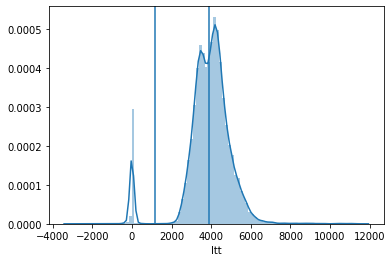

In [93]:
sns.distplot(teste, 100)
plt.axvline(teste.mean())
plt.axvline(teste.std())

In [119]:
teste.mean()

3868.769516561824

In [198]:
# Cálculo dos betas
c[(c['aproxlinkstart'] >= '2017-05-02 04:00:00') & (c['aproxlinkstart'] <= '2017-05-02 22:00:00') & (c['link'] == '(18032, 16066)')]

_id      aproxlinkstart            link         ltt  \
0    5c76efc0bd8143570ffe832e 2017-05-02 04:10:53  (18032, 16066)   35.167562   
1    5c76efc0bd8143570ffe832f 2017-05-02 04:21:46  (18032, 16066)   80.460363   
2    5c76efc0bd8143570ffe8330 2017-05-02 04:25:19  (18032, 16066)   57.644096   
3    5c76efc0bd8143570ffe8331 2017-05-02 04:29:36  (18032, 16066)   77.556789   
4    5c76efc0bd8143570ffe8332 2017-05-02 04:36:52  (18032, 16066)   95.793777   
5    5c76efc0bd8143570ffe8333 2017-05-02 04:40:16  (18032, 16066)   73.472926   
6    5c76efc0bd8143570ffe8334 2017-05-02 04:46:50  (18032, 16066)   95.793777   
7    5c76efc0bd8143570ffe8335 2017-05-02 04:50:35  (18032, 16066)   77.030665   
8    5c76efc0bd8143570ffe8336 2017-05-02 05:01:13  (18032, 16066)   85.980749   
9    5c76efc0bd8143570ffe8337 2017-05-02 05:04:38  (18032, 16066)  112.830818   
10   5c76efc0bd8143570ffe8338 2017-05-02 05:09:33  (18032, 16066)  125.040015   
11   5c76efc0bd8143570ffe8339 2017-05-02 05:14:26  (18032, 16066)  126.918273   
12   5c76efc0bd8143570ffe833a 2017-05-02 05:25:37  (18032, 16066)   86.838466   
13   5c76efc0bd8143570ffe833b 2017-05-02 05:28:10  (18032, 16066)   95.793777   
14   5c76efc0bd8143570ffe833c 2017-05-02 05:29:40  (18032, 16066)  143.730161   
15   5c76efc0bd8143570ffe833d 2017-05-02 05:33:55  (18032, 16066)  128.449956   
16   5c76efc0bd8143570ffe833e 2017-05-02 05:38:39  (18032, 16066)    2.775993   
17   5c76efc0bd8143570ffe833f 2017-05-02 05:44:30  (18032, 16066)   95.793777   
18   5c76efc0bd8143570ffe8340 2017-05-02 05:47:36  (18032, 16066)  113.738495   
19   5c76efc0bd8143570ffe8341 2017-05-02 05:54:19  (18032, 16066)   95.793777   
20   5c76efc0bd8143570ffe8342 2017-05-02 05:57:13  (18032, 16066)   97.483538   
21   5c76efc0bd8143570ffe8343 2017-05-02 05:59:33  (18032, 16066)  176.044248   
22   5c76efc0bd8143570ffe8344 2017-05-02 06:05:39  (18032, 16066)  148.429039   
23   5c76efc0bd8143570ffe8345 2017-05-02 06:09:00  (18032, 16066)  143.976338   
24   5c76efc0bd8143570ffe8346 2017-05-02 06:15:53  (18032, 16066)    0.010206   
25   5c76efc0bd8143570ffe8347 2017-05-02 06:19:12  (18032, 16066)   76.998825   
26   5c76efc0bd8143570ffe8348 2017-05-02 06:29:29  (18032, 16066)  122.023638   
27   5c76efc0bd8143570ffe8349 2017-05-02 06:32:26  (18032, 16066)  151.618813   
28   5c76efc0bd8143570ffe834a 2017-05-02 06:35:37  (18032, 16066)  142.996079   
29   5c76efc0bd8143570ffe834b 2017-05-02 06:41:04  (18032, 16066)   85.989840   
..                        ...                 ...             ...         ...   
122  5c76efc0bd8143570ffe83a8 2017-05-02 17:48:27  (18032, 16066)   95.793777   
123  5c76efc0bd8143570ffe83a9 2017-05-02 17:54:36  (18032, 16066)   67.349555   
124  5c76efc0bd8143570ffe83aa 2017-05-02 17:58:58  (18032, 16066)  102.711297   
125  5c76efc0bd8143570ffe83ab 2017-05-02 18:06:44  (18032, 16066)  100.837119   
126  5c76efc0bd8143570ffe83ac 2017-05-02 18:11:51  (18032, 16066)  159.956134   
127  5c76efc0bd8143570ffe83ad 2017-05-02 18:23:51  (18032, 16066)   59.329010   
128  5c76efc0bd8143570ffe83ae 2017-05-02 18:25:38  (18032, 16066)  118.356268   
129  5c76efc0bd8143570ffe83af 2017-05-02 18:30:12  (18032, 16066)   70.724968   
130  5c76efc0bd8143570ffe83b0 2017-05-02 18:44:30  (18032, 16066)   96.476873   
131  5c76efc0bd8143570ffe83b1 2017-05-02 18:53:49  (18032, 16066)   53.777164   
132  5c76efc0bd8143570ffe83b2 2017-05-02 19:01:02  (18032, 16066)   77.647764   
133  5c76efc0bd8143570ffe83b3 2017-05-02 19:09:38  (18032, 16066)   99.855350   
134  5c76efc0bd8143570ffe83b4 2017-05-02 19:16:27  (18032, 16066)  100.147441   
135  5c76efc0bd8143570ffe83b5 2017-05-02 19:25:27  (18032, 16066)    0.000982   
136  5c76efc0bd8143570ffe83b6 2017-05-02 19:28:46  (18032, 16066)   95.793777   
137  5c76efc0bd8143570ffe83b7 2017-05-02 19:40:01  (18032, 16066)  107.675913   
138  5c76efc0bd8143570ffe83b8 2017-05-02 19:49:07  (18032, 16066)  108.528351   
139  5c76efc0bd8143570ffe83b9 2017-05-02 19:50:08  (18032

In [51]:
linhas = pd.read_csv('shape.txt')
paradas = pd.read_csv('stops.txt')
viagem = pd.read_csv('trips.txt')

In [46]:
linhas.head()

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
0     63442    -23.432172    -46.787096                  1   
1     63442    -23.432116    -46.787105                  2   
2     63442    -23.431590    -46.787191                  3   
3     63442    -23.431476    -46.787206                  4   
4     63442    -23.431429    -46.787211                  5   

   shape_dist_traveled  
0             0.000000  
1             6.269753  
2            65.183495  
3            77.901642  
4            83.131508

In [48]:
paradas.head()

stop_id      stop_name stop_desc   stop_lat   stop_lon
0    18848       Clínicas       NaN -23.554190 -46.670723
1    18849  Vila Madalena       NaN -23.546720 -46.690738
2    18850     Consolação       NaN -23.557503 -46.660870
3    18851      Conceição       NaN -23.636214 -46.641141
4    18852      Jabaquara       NaN -23.645754 -46.642084

In [56]:
viagem.head()
viagem[viagem['route_id']=='675K-10']

route_id service_id    trip_id     trip_headsign  direction_id  shape_id
1408  675K-10        USD  675K-10-0   Metrô Sta. Cruz             0     54897
1409  675K-10        USD  675K-10-1  Term. Jd. âNgela             1     60424

In [86]:
l675 = linhas[linhas['shape_id']==54897]
l675.tail()

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
495510     54897    -23.598668    -46.637561                343   
495511     54897    -23.598984    -46.637565                344   
495512     54897    -23.599110    -46.637566                345   
495513     54897    -23.599304    -46.637569                346   
495514     54897    -23.599410    -46.637570                347   

        shape_dist_traveled  
495510            19587.770  
495511            19622.770  
495512            19636.725  
495513            19658.213  
495514            19669.953

In [131]:
from geo import circle_dist

w = circle_dist(-23.689609733095438, -46.77345727770849, -23.68628318749556, -46.77055481875523)
print(w)
x = circle_dist(-23.690466, -46.773692, -23.690568, -46.773793)
y = circle_dist(-23.690568, -46.773793, -23.690627,-46.773852)
z = circle_dist(-23.690627,-46.773852, -23.690715,-46.773940)
(x + y + z)*1000 - 37.421383

0.4736149482280331


0.06388595317123702

In [82]:
dist = circle_dist(l675['shape_pt_lat'], l675['shape_pt_lon'], l675['shape_pt_lat'].shift(), l675['shape_pt_lon'].shift())

In [89]:
dist.sum()*1000

19689.30187855746

In [93]:
((dist.sum() - 19.669953)/40)*3600

1.7413990701716031

In [108]:
%time
a = querylist1('675K-10-0', 3)
%time
a.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


_id      aproxlinkstart            link        ltt  \
0  5c76efc0bd8143570ffe5fc5 2017-03-01 04:10:42  (18032, 16066)  88.305676   
1  5c76efc0bd8143570ffe5fc6 2017-03-01 04:16:16  (18032, 16066)  56.873849   
2  5c76efc0bd8143570ffe5fc7 2017-03-01 04:21:09  (18032, 16066)  54.405060   
3  5c76efc0bd8143570ffe5fc8 2017-03-01 04:25:52  (18032, 16066)  80.610608   
4  5c76efc0bd8143570ffe5fc9 2017-03-01 04:31:22  (18032, 16066)  78.276444   

   travel_id    trip_id  headway  
0       7247  675K-10-0      NaT  
1       7248  675K-10-0 00:05:34  
2       7249  675K-10-0 00:04:53  
3       7250  675K-10-0 00:04:43  
4       7251  675K-10-0 00:05:30

In [214]:
alpha = c.loc[0]
alpha[alpha['link']== '(18032, 16066)']

_id      aproxlinkstart            link        ltt  \
0  5c76efc0bd8143570ffe82c5 2017-05-01 04:16:53  (18032, 16066)  87.123630   
0  5c76efc0bd8143570ffe832e 2017-05-02 04:10:53  (18032, 16066)  35.167562   
0  5c76efc0bd8143570ffe83ce 2017-05-03 04:10:38  (18032, 16066)  78.076446   
0  5c76efc0bd8143570ffe8474 2017-05-04 04:13:00  (18032, 16066)  89.415714   
0  5c76efc0bd8143570ffe8525 2017-05-05 04:11:52  (18032, 16066)  95.793777   

   travel_id    trip_id  headway  
0      16207  675K-10-0        0  
0      16312  675K-10-0        0  
0      16472  675K-10-0        0  
0      16638  675K-10-0        0  
0      16815  675K-10-0        0

## __Referências__


https://linux.ime.usp.br/~andreky/AndreYai_monografia_revisada.pdf

[A headway-based approach to eliminate bus bunching: Systematic analysis and comparisons - Carlos Daganzo]

https://www.sciencedirect.com/science/article/pii/S0191261509000484

[Dados abertos SPTrans]

https://www.prefeitura.sp.gov.br/cidade/secretarias/transportes/institucional/sptrans/acesso_a_informacao/index.php?p=228269

[Edital Prefeitura de SP 2018]

https://www.prefeitura.sp.gov.br/cidade/secretarias/transportes/edital/index.php?p=268507

[Relatório FIPE em parceria com UBER para analisar congestionamentos na cidade de São Paulo]

https://movement.uber.com/explore/sao_paulo/travel-times/query?si=311&ti=54&ag=od_zones_2017&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5&dt[dr][sd]=2018-12-01&dt[dr][ed]=2018-12-31&cd[tpb]=ALL_DAY&cd[wd;]=6,7&cd[dr][sd]=2018-12-01&cd[dr][ed]=2018-12-31&sa;=-46.7739927,-23.6905823&sdn=Terminal%20Jardim%20Angela,%20Estrada%20do%20M%27Boi%20Mirim,%203630,%20S%C3%A3o%20Paulo%20-%20SP&lng.=-46.6944524&lat.=-23.6432138&z.=12&ta;=-46.6371836,-23.5990754&tdn=Shopping%20Metro%20Santa%20Cruz,%20R.%20Domingos%20de%20Morais,%202564,%20S%C3%A3o%20Paulo%20-%20SP&lang=en-US

https://uber.app.box.com/v/relatorio-fipe

## __Cursos e Tutoriais__

https://towardsdatascience.com/data-visualization-with-python-folium-maps-a74231de9ef7

https://uci.service-now.com/kb_view.do?sysparm_article=KB0010201

https://towardsdatascience.com/why-and-how-to-use-merge-with-pandas-in-python-548600f7e738

https://towardsdatascience.com/coding-ml-tools-like-you-code-ml-models-ddba3357eace

[Streamlit]

https://www.youtube.com/channel/UC3LD42rjj-Owtxsa6PwGU5Q/featured

[Testes de normalidade]

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

[Listas das curvas de probabilidade para teste de normalidade]

https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats

[Transformar dados para obter normalidade]

https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/

In [ ]:
# Resampling
from sklearn.utils import resample

smp = []
for i in range(1000):
    smp.append(resample(routeAdj[(routeAdj['dayweek']==0) & (routeAdj['hour']==10) & (routeAdj['link']=='(18032, 16066)')].ltt, replace=True, n_samples=20))
smp = np.asarray(smp)
smp

np.asarray(smp[0]).mean()

ops = []
for i in range(100):
    ops.append(smp[i].mean())
    
np.asarray(ops).mean()

In [ ]:
latitude = -23.63870248774502
longitude = -46.695343900467726
map_675K = folium.Map(location=[latitude, longitude], zoom_start=13)
folium.CircleMarker([-23.689609733095438,-46.77345727770849],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(18032, 16066)
folium.CircleMarker([-23.68628318749556, -46.77055481875523],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(16066, 14997)
folium.CircleMarker([-23.683171399269526, -46.76871557818051],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14997, 14998)
folium.CircleMarker([-23.680571130689255, -46.76526057729619],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14998, 14999)
folium.CircleMarker([-23.6777213667861, -46.76192016390048],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14999, 16018)
folium.CircleMarker([-23.675529772436324, -46.75646643451084],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(16018, 15784)
folium.CircleMarker([-23.676123755116286, -46.74974082335898],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15784, 15785)
folium.CircleMarker([-23.673687480165803, -46.74585534114545],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15785, 15006)
folium.CircleMarker([-23.672487781984362, -46.74288535508426],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15006, 15007)
folium.CircleMarker([-23.67096112304264, -46.73991405013386],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15007, 15008)
folium.CircleMarker([-23.669892695174184, -46.7369705718029],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15008, 14192)
folium.CircleMarker([-23.66856088697897, -46.73311954376861],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14192, 14193)
folium.CircleMarker([-23.667140135601457, -46.72533997804064],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14193, 14194)
folium.CircleMarker([-23.66631234395268, -46.71753151940268],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14194, 14955)
folium.CircleMarker([-23.66526970590957, -46.71063976307338],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14955, 15010)
folium.CircleMarker([-23.659384863996063, -46.70525972223886],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15010, 15011)
folium.CircleMarker([-23.65324523651312, -46.70635517293211],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(15011, 14695)
folium.CircleMarker([-23.650469131180028, -46.70436905773142],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14695, 14696)
folium.CircleMarker([-23.64686366511044, -46.70186901709655],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14696, 14697)
folium.CircleMarker([-23.64250259764584, -46.69882506050396],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14697, 14698)
folium.CircleMarker([-23.63870248774502, -46.695343900467726],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14698, 14699)
folium.CircleMarker([-23.634895089634398, -46.691642753222155],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14699, 14700)
folium.CircleMarker([-23.63114074550968, -46.68808869566962],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14700, 14701)
folium.CircleMarker([-23.627421607696526, -46.68463051374957],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(14701, 13751)
folium.CircleMarker([-23.62309375221328, -46.680430350436374],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13751, 13752)
folium.CircleMarker([-23.619401999757017, -46.67696500962723],color='orange',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13752, 13753)
folium.CircleMarker([-23.617011418741775, -46.674700985023094],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13753, 13754)
folium.CircleMarker([-23.613319813551286, -46.67123026472163],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13754, 13755)
folium.CircleMarker([-23.60885684069856, -46.66703270601057],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13755, 13756)
folium.CircleMarker([-23.604937966180984, -46.66335393143781],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13756, 13757)
folium.CircleMarker([-23.601141310665803, -46.659824723099064],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(13757, 18033)
folium.CircleMarker([-23.597007025365226, -46.655908435956476],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(18033, 18034)
folium.CircleMarker([-23.596378722121685, -46.65129929250486],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(18034, 12498)
folium.CircleMarker([-23.596689323678955, -46.64740355836816],color='yellow',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(12498, 12499)
folium.CircleMarker([-23.597013555528715, -46.643709408714315],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(12499, 18035)
folium.CircleMarker([-23.59753482192534, -46.639852010823034],color='green',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K) #(18035, 18036)
folium.CircleMarker([-23.598472325967524, -46.63757565775048],color='red',fill=True,fill_opacity=0.7, radius = 5).add_to(map_675K)
map_675K

In [ ]:
# Função para inserir elementos no mapa
latitude = -23.63870248774502
longitude = -46.695343900467726
map_675K = folium.Map(location=[latitude, longitude], zoom_start=13)

#Popup deve ser uma string ou um objeto Vega (Visual Elements)
def add_marker(row):
    folium.CircleMarker([-23.598472325967524, -46.63757565775048],color='red',fill=True,fill_opacity=0.7, radius = 5, popup = row['time'].strftime('%H:%M')).add_to(map_675K)

# esta linha roda para um elemento
row = df.iloc[321]
add_marker[row]

#esta linha roda para cada linha do dataframe
df.apply(add_marker, axis = 1)

m

In [ ]:
# Função para retornar as tuplas dos mid points da trajetória
# Em bus_id inserir o número da linha no formato '675K-10-0'
def link_tuple(bus_id):
    with open('linesedges.pkl', 'rb') as input_file:
        linesedges = pickle.load(input_file)
    return linesedges[bus_id]

In [ ]:
link_tuple('675K-10-0')

In [ ]:
def days_month(month):
    monthlist1 = [1,3,5,7,8,10,12] # monthlist for months with 31 days.
    monthlist2 = [4,6,9,11] ## monthlist for months with 30 days.
    monthlist3 = 2 ## month with month with 28 days.
    
    if month in monthlist1:
        return 5
    elif month in monthlist2:
        return 30
    else:
        return 28

In [ ]:
def querylist(bus_id, month):
    
    acc = pd.DataFrame()
    lt = link_tuple(bus_id)
    
    for i in range(1, days_month(month) + 1):
        dateb = dateutil.parser.parse("2017" + "-" + str(month) + "-" + str(i) + "T04:00:00")
        datee = dateutil.parser.parse("2017" + "-" + str(month) + "-" + str(i) + "T23:59:59")
        
        
        for j in range(0, len(lt)):
            q = {'trip_id': bus_id, "aproxlinkstart": {"$gte": dateb, "$lt": datee}, "link": str(lt[j])}
            conn = MongoClient('172.17.163.239')
            select = pd.DataFrame.from_records(conn['linktt']['ltts'].find(q))
            conn.close()            
            
            v = []
            for k in range(0, select.shape[0] - 1):
                v.append(round((select['aproxlinkstart'][k + 1] - select['aproxlinkstart'][k]).total_seconds()))
            
            v.insert(0,0)
            select['headway'] = v
            acc = pd.concat([acc, select])

    return acc

In [ ]:
# Query list com shift em vez de mais um for-loop
def querylist1(bus_id, month):
    
    acc = pd.DataFrame()
    lt = link_tuple(bus_id)
    
    for i in range(1, days_month(month) + 1):
        dateb = dateutil.parser.parse("2017" + "-" + str(month) + "-" + str(i) + "T04:00:00")
        datee = dateutil.parser.parse("2017" + "-" + str(month) + "-" + str(i) + "T23:59:59")
        
        
        for j in range(0, len(lt)):
            q = {'trip_id': bus_id, "aproxlinkstart": {"$gte": dateb, "$lt": datee}, "link": str(lt[j])}
            conn = MongoClient('172.17.163.239')
            select = pd.DataFrame.from_records(conn['linktt']['ltts'].find(q))
            conn.close()
            
            select['headway'] = select['aproxlinkstart'] - select['aproxlinkstart'].shift()
            #select['headway'] = (select['aproxlinkstart'] - select['aproxlinkstart'].shift()).dt.total_seconds() total em segundos

            
            acc = pd.concat([acc, select])

    return acc

In [ ]:
# Teste de performance das queries
import time
start = time.time()
c = querylist('675K-10-0', 5)
end = time.time()
print(end - start)

In [ ]:
# Observamos que a query com shift aparentemente possui uma performance melhor
import time
start = time.time()
b = querylist1('675K-10-0', 5)
end = time.time()
print(end - start)

### __Análise dos tempos de viagens para cada link__

Foi identificado que para o link _(18032, 16066)_ os valores estavam sempre pŕoximos de 95s. Isso porque na interpolação faltava um ponto e no código pegava a mediana do trecho. Por esta razão, muitos valores ficaram exatamente iguais. Para o modelo optamos por descartar o link _(18032, 16066)_.

In [ ]:
# Vamos extrair as tuplas que identificam cada um dos segmentos da linha 675K-10-0
mid_points = link_tuple('675K-10-0')

In [ ]:
# Para cada link vamos verificar a distribuição dos valores de entrada e saída do link em unidade de tempo (s) e plotar os gráficos
link1 = c[c['link'] == '(18032, 16066)']
print("Média: ", link1['ltt'].mean(), ' | ',"Desvio Padrão: ",link1['ltt'].std())
plt.axvline(link1['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(link1['ltt'].mean() - link1['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(link1['ltt'].mean() + link1['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
fig1 = plt.hist(link1['ltt'], 50)
plt.show()

In [ ]:
link2 = c[c['link'] == '(16066, 14997)']
print("Média: ", link2['ltt'].mean(), ' | ',"Desvio Padrão: ",link2['ltt'].std())
plt.axvline(link2['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(link2['ltt'].mean() - link2['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(link2['ltt'].mean() + link2['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
fig2 = plt.hist(link2['ltt'], 50)
plt.show()

In [ ]:
link3 = c[c['link'] == '(14997, 14998)']
print("Média: ", link3['ltt'].mean(), ' | ',"Desvio Padrão: ",link3['ltt'].std())
plt.axvline(link3['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(link3['ltt'].mean() - link3['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(link3['ltt'].mean() + link3['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
fig3 = plt.hist(link3['ltt'], 50)
plt.show()

In [ ]:
link4 = c[c['link'] == '(14998, 14999)']
print("Média: ", link4['ltt'].mean(), ' | ',"Desvio Padrão: ",link4['ltt'].std())
plt.axvline(link4['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(link4['ltt'].mean() - link4['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(link4['ltt'].mean() + link4['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
fig4 = plt.hist(link4['ltt'], 50)
plt.show()

In [ ]:
link5 = c[c['link'] == '(14999, 16018)']
print("Média: ", link5['ltt'].mean(), ' | ',"Desvio Padrão: ",link5['ltt'].std())
plt.axvline(link5['ltt'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(link5['ltt'].mean() - link5['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(link5['ltt'].mean() + link5['ltt'].std(), color='red', linestyle='dashed', linewidth=1)
fig5 = plt.hist(link5['ltt'], 50)
plt.show()

272 days can be converted to one of these units:

    23.500.800 seconds
    391.680 minutes
    6528 hours
    272 days
    38 weeks and 6 days
    74,52% of 2017
    
__processar na maquina da federal__    

* nohup python -u < file > &
    
* tail nohup.out